# Project 4： Regression Analysis
In this project, we are working with "Network backup Dataset" and performing different regession models onto it. By trying different regression methods (linear regression model, random forest regression model, neural network regression model and k-nearest neighbor regression model) along with different preprocessing techniques (one-hot-encoder, standardization and polynomials) and diffrent regularization techniques, we are able to compare the performance of different methods based on train RMSE and test RMSE. By drawing figures on fitted values and predicted values, we can gain a better understanding on how different regression methods can affect the prediction results.

## Problem 1 Load the dataset

### (a) For a twenty-day period (X-axis unit is day number) plot the backup sizes for all workflows (color coded on the Y-axis)
- We firstly extract the data for twenty-day period, and then sum up the backup size for each file for each day, and finally plot the backup size vs time for each workflow.
- We provide the line-plot and scatter-plot for this question since some of the data will be too low to be seen in a line-plot (eg. workflow-3). It is clear that there exists a periodic pattern of backup size vs time for each workflow and their periods are around seven-days.

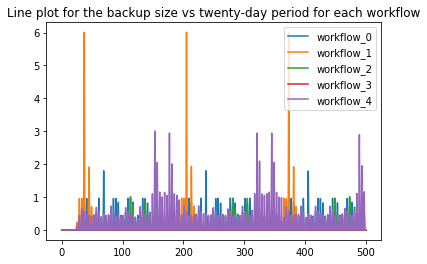

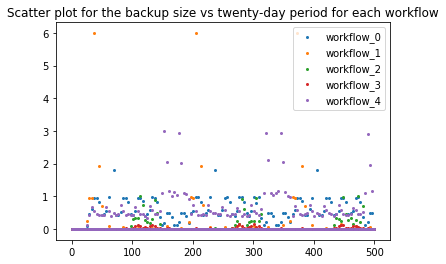

In [1]:
# (a)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('network_backup_dataset.csv')
Week_No = data['Week #']
data = data.replace({'Day of Week': {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}})
Day = data['Day of Week']

# first twenty days
first_two_weeks = data.loc[Week_No <=2, :]
rest_days = data[(Week_No == 3) & (Day <= 6)]
twenty_days = pd.concat([first_two_weeks, rest_days])
twenty_days['Time'] = twenty_days[['Week #', 'Day of Week', 'Backup Start Time - Hour of Day']] \
    .apply(lambda x: (x['Week #'] - 1) * 7 * 24 + x['Day of Week'] * 24 + x['Backup Start Time - Hour of Day'], axis=1)
twenty_days = twenty_days.replace({'Work-Flow-ID': {'work_flow_0':0, 'work_flow_1':1, 'work_flow_2':2, 'work_flow_3':3, 'work_flow_4':4}})
  

for i in np.arange(0,5):
    workflow_rows = twenty_days.loc[twenty_days['Work-Flow-ID'] == i, :]
    backup_size_rec = []
    for j in np.arange(max(twenty_days['Time'])):

        backup_size = sum(workflow_rows.loc[workflow_rows['Time'] == j, 'Size of Backup (GB)'])
        backup_size_rec.append(backup_size)
    
    plt.plot(np.arange(max(twenty_days['Time'])), backup_size_rec, label = 'workflow_'+str(i))
plt.legend(loc = 'upper right') 
plt.title('Line plot for the backup size vs twenty-day period for each workflow')
plt.show() 

for i in np.arange(0,5):
    workflow_rows = twenty_days.loc[twenty_days['Work-Flow-ID'] == i, :]
    backup_size_rec = []
    for j in np.arange(max(twenty_days['Time'])):

        backup_size = sum(workflow_rows.loc[workflow_rows['Time'] == j, 'Size of Backup (GB)'])
        backup_size_rec.append(backup_size)
    
    plt.scatter(np.arange(max(twenty_days['Time'])), backup_size_rec, label = 'workflow_'+str(i), s=4)
plt.legend(loc = 'upper right') 
plt.title('Scatter plot for the backup size vs twenty-day period for each workflow')
plt.show() 

    

### (b) Do the same plot for the first 105-day period.
- We do a similar job here except that we change twenty-day period to 105-day period. There still exists periodic patterns with a period of around seven-days.

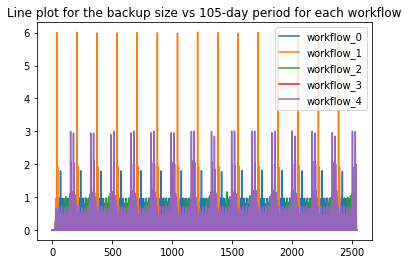

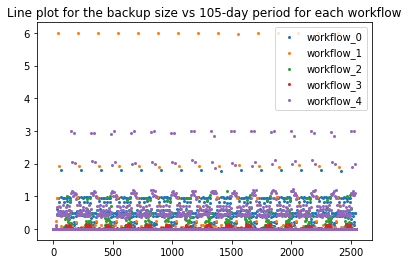

In [2]:
# (b)
# first 105-day period: = 15 weeks
first_fifteen_weeks = data.loc[Week_No <=15, :]
first_fifteen_weeks['Time'] = first_fifteen_weeks[['Week #', 'Day of Week', 'Backup Start Time - Hour of Day']] \
    .apply(lambda x: (x['Week #'] - 1) * 7 * 24 + x['Day of Week'] * 24 + x['Backup Start Time - Hour of Day'], axis=1)
first_fifteen_weeks = first_fifteen_weeks.replace({'Work-Flow-ID': {'work_flow_0':0, 'work_flow_1':1, 'work_flow_2':2, 'work_flow_3':3, 'work_flow_4':4}})    

for i in np.arange(0,5):
    workflow_rows = first_fifteen_weeks.loc[first_fifteen_weeks['Work-Flow-ID'] == i, :]
    backup_size_rec = []
    for j in np.arange(max(first_fifteen_weeks['Time'])):

        backup_size = sum(workflow_rows.loc[workflow_rows['Time'] == j, 'Size of Backup (GB)'])
        backup_size_rec.append(backup_size)
    
    plt.plot(np.arange(max(first_fifteen_weeks['Time'])), backup_size_rec, label = 'workflow_'+str(i))
    plt.legend(loc = 'upper right') 
plt.title('Line plot for the backup size vs 105-day period for each workflow')
plt.show()  

for i in np.arange(0,5):
    workflow_rows = first_fifteen_weeks.loc[first_fifteen_weeks['Work-Flow-ID'] == i, :]
    backup_size_rec = []
    for j in np.arange(max(first_fifteen_weeks['Time'])):

        backup_size = sum(workflow_rows.loc[workflow_rows['Time'] == j, 'Size of Backup (GB)'])
        backup_size_rec.append(backup_size)
    
    plt.scatter(np.arange(max(first_fifteen_weeks['Time'])), backup_size_rec, label = 'workflow_'+str(i), s=4)
    plt.legend(loc = 'upper right') 
plt.title('Line plot for the backup size vs 105-day period for each workflow')
plt.show()  


## Problem 2 Predict

- In the problem 2, for each part from (a) to (e), we need to report the training and testing RMSE from 10-fold cross-validation and show two plots. To make things easier, we define a function *two_plots* here which is used to plot the two plots. The first one is for plotting the fitted values against true values scattered over the number of data points and the second plot is for residuals versus fitted values scattered over the number of data points.

In [3]:
def two_plots(actual, cv_fitted):
    # In addition, you need to: 
#     # (i) Plot fitted values against true values scattered over the number of data points
    fig, ax = plt.subplots()
    ax.scatter(np.arange(actual.shape[0]), actual, s = 1, label = 'actual values')
    ax.scatter(np.arange(actual.shape[0]), cv_fitted, s =1,  label = 'fitted values')
    ax.set_xlabel('Time')
    ax.set_ylabel('Fitted and actual values')
    plt.legend(loc='upper right')
    plt.show()

    # (ii) Plot residuals versus fitted values scattered over the number of data points using the whole dataset 
    # for each model with the best parameters you have found
    fig, ax = plt.subplots()
    ax.scatter(np.arange(actual.shape[0]), actual-cv_fitted, s = 1, label = 'residual')
    ax.scatter(np.arange(actual.shape[0]), cv_fitted, s =1,  label = 'fitted values')

    ax.set_xlabel('Time')
    ax.set_ylabel('Residual and fitted values')
    plt.legend(loc='upper right')
    plt.show()    

### (a) Fit a linear regression model

#### i.  First convert each categorical feature into one dimensional numerical values using scalar encoding (e.g. Monday to Sunday can be mapped to 1-7), and then directly use them to fit a basic linear regression model.
> - Since in the given Network dataset, many data are not numerically encoded, eg. 'File_0', it is unable to perform numerical computation onto such data, the first thing is to use .replace method in the pandas to turn 'File_0' to 0. 
> - We then split the data and targets to 10 folds, and each time we choose 9 folds as training data and 1 fold as testing data to perform 10-fold cross validation. Each time, we construct a new linear regression model by calling *linear_model.LinearRegression* provided by sklearn, and calculate the train RMSE and test RMSE and finally plot the two figures based on fitted values and true values.



> - Train RMSE = 0.10359
> - Test RMSE = 0.10368
> - These RMSE are reasonable since that even train data cannot perfectly align on a line, therefore train data should have small RMSE. As for test RMSE, it should also be small if there is no overfitting while it should be a little bit larger than train RMSE, which is consistent with our results.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Training RMSE: 0.10359
Testing RMSE: 0.10368


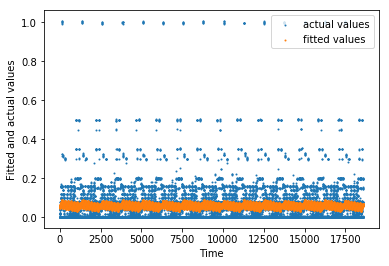

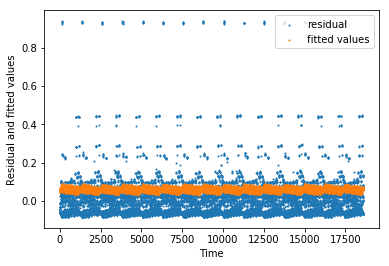

In [4]:
# (a) i
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
# import statsmodels.api as sm

data = pd.read_csv('network_backup_dataset.csv')
data = data.replace({'Day of Week': {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}})
data = data.replace({'Work-Flow-ID': {'work_flow_0':0, 'work_flow_1':1, 'work_flow_2':2, 'work_flow_3':3, 'work_flow_4':4}})
data = data.replace({'File Name': {'File_0':0, 'File_1':1, 'File_2':2, 'File_3':3, 'File_4':4, 'File_5':5, 'File_6':6, 'File_7':7,
                                   'File_8':8, 'File_9':9, 'File_10':10, 'File_11':11, 'File_12':12, 'File_13':13, 'File_14':14,
                                   'File_15':15, 'File_16':16, 'File_17':17, 'File_18':18, 'File_19':19, 'File_20':20, 'File_21':21, 
                                   'File_22':22, 'File_23':23, 'File_24':24, 'File_25':25, 'File_26':26, 'File_27':27, 'File_28':28,
                                   'File_29':29}})
X = data[['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']]
y = data['Size of Backup (GB)']

num_folds = 10
X_folds = np.array_split(X, num_folds, axis = 0)
y_folds = np.array_split(y, num_folds)
# print(X_folds)
train_RMSE = 0
test_RMSE = 0
for i in np.arange(10):
    X_train = np.vstack(X_folds[:i] + X_folds[i+1:]) 
    X_test = X_folds[i]
#     print(X_test)
    y_train = np.hstack(y_folds[:i] + y_folds[i+1:]) 
    y_test = y_folds[i]
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)

    train_RMSE += mean_squared_error(y_train, y_train_pred)
    test_RMSE += mean_squared_error(y_test, y_test_pred)
    
train_RMSE = np.sqrt(train_RMSE/num_folds)
test_RMSE = np.sqrt(test_RMSE/num_folds)

print("Training RMSE: %.5f" % train_RMSE)
print("Testing RMSE: %.5f" % test_RMSE)
y_pred = cross_val_predict(lr, X, y, cv = num_folds)
two_plots(y, y_pred)


#### ii. Data Preprocessing: Standardize (see the Useful Functions Section) all these numerical features, then fit and test the model. How does the fitting result change as shown in the plots?
> - Except than directly use the scalar encoding data to train the linear regression model, we firstly standardize the data. Then, everything is the same with the previous question. 


> - Train RMSE = 0.10359
> - Test RMSE = 0.10368
> - We can observe that the train and test RMSE are similar as the previous question, which indicates that standardization can have little impact on this dataset when using linear regression model.

Training RMSE: 0.10359
Testing RMSE: 0.10368


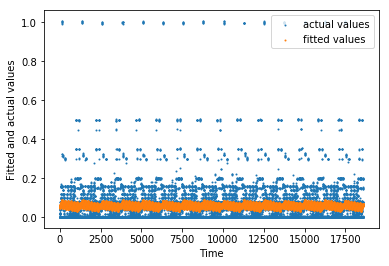

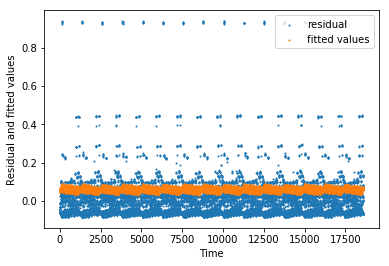

In [5]:
# (a) ii
from sklearn.preprocessing import StandardScaler

num_folds = 10
X = data[['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']]
y = data['Size of Backup (GB)']
X = StandardScaler().fit_transform(X)

X_folds = np.array_split(X, num_folds, axis = 0)
y_folds = np.array_split(y, num_folds)

train_RMSE = 0
test_RMSE = 0
for i in np.arange(10):
    X_train = np.vstack(X_folds[:i] + X_folds[i+1:]) 
    X_test = X_folds[i]
    y_train = np.hstack(y_folds[:i] + y_folds[i+1:]) 
    y_test = y_folds[i]
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)

    train_RMSE += mean_squared_error(y_train, y_train_pred)
    test_RMSE += mean_squared_error(y_test, y_test_pred)

train_RMSE = np.sqrt(train_RMSE/num_folds)
test_RMSE = np.sqrt(test_RMSE/num_folds)

print("Training RMSE: %.5f" % train_RMSE)
print("Testing RMSE: %.5f" % test_RMSE)

y_pred = cross_val_predict(lr, X, y, cv = num_folds)
two_plots(y, y_pred)



#### iii. Feature Selection: Use f regression and mutual information regression measure to select three most important variables respectively. Report the three most important variables you find. Use those three most important variables to train a new linear model, does the performance improve?
>- The three most important variables chosen by f_regression are 'Day of Week', 'Backup Start Time - Hour of Day', 'File Name' since they three have relatively high f_regression scores, and there is small improvement that the test RMSE goes down a little bit.
>- The three most important variables chosen by m_regression are 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name' since they have relatively high mutual information regression scores. However, by using these three variables, the performance goes worse.


>- After performing linear regression with three most important variables found by f-regression, the train RMSE is 0.10359 and the test RMSE is 0.10367.
>- After performing linear regression with three most important variables found by m-regression, the train RMSE is 0.10369 and the test RMSE is 0.10377.
>- Two required plots corresponding to f_regression and m_regression are just after the codes.

In [25]:
# (a) iii
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
f_filter = SelectKBest(f_regression, k=3)
f_fit = f_filter.fit(X_test, y_test)
# print(X.keys()[0])
# X = data[['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']]
np.set_printoptions(precision=3)
print(f_fit.scores_)

m_filter = SelectKBest(mutual_info_regression, k=3)
m_fit = m_filter.fit(X_test, y_test)
print(m_fit.scores_)


[ 0.572  4.462 33.333  0.882  0.628]
[0.    0.211 0.25  0.274 0.454]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Using the three most important variables selected by f_regression:
Training RMSE: 0.10359
Testing RMSE: 0.10367


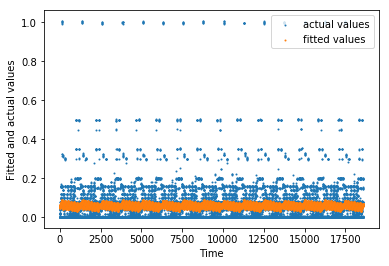

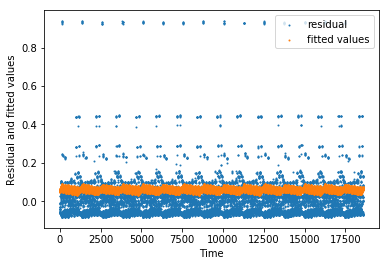

Using the three most important variables selected by m_regression:
Training RMSE: 0.10369
Testing RMSE: 0.10377


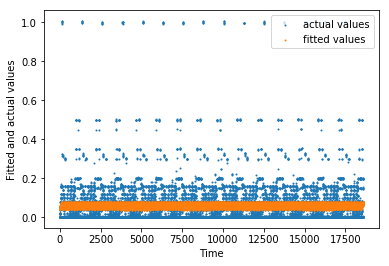

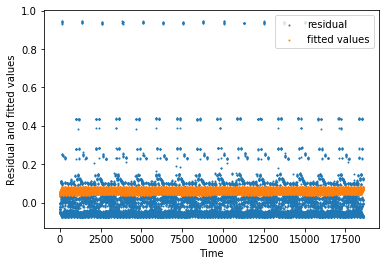

In [26]:
# f_regression
X_new = data[['Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID']]
y_new = data['Size of Backup (GB)']

num_folds = 10
X_folds = np.array_split(X_new, num_folds, axis = 0)
y_folds = np.array_split(y_new, num_folds)

train_RMSE = 0
test_RMSE = 0
for i in np.arange(10):
    X_train = np.vstack(X_folds[:i] + X_folds[i+1:]) 
    X_test = X_folds[i]
    y_train = np.hstack(y_folds[:i] + y_folds[i+1:]) 
    y_test = y_folds[i]
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)

    train_RMSE += mean_squared_error(y_train, y_train_pred)
    test_RMSE += mean_squared_error(y_test, y_test_pred)

train_RMSE = np.sqrt(train_RMSE/num_folds)
test_RMSE = np.sqrt(test_RMSE/num_folds)
print('Using the three most important variables selected by f_regression:')
print("Training RMSE: %.5f" % train_RMSE)
print("Testing RMSE: %.5f" % test_RMSE)
y_pred = cross_val_predict(lr, X_new, y_new, cv = num_folds)
two_plots(y, y_pred)


# m_regression
X_new = data[['Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']]
y_new = data['Size of Backup (GB)']

num_folds = 10
X_folds = np.array_split(X_new, num_folds, axis = 0)
y_folds = np.array_split(y_new, num_folds)

train_RMSE = 0
test_RMSE = 0
for i in np.arange(10):
    X_train = np.vstack(X_folds[:i] + X_folds[i+1:]) 
    X_test = X_folds[i]
    y_train = np.hstack(y_folds[:i] + y_folds[i+1:]) 
    y_test = y_folds[i]
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)

    train_RMSE += mean_squared_error(y_train, y_train_pred)
    test_RMSE += mean_squared_error(y_test, y_test_pred)

train_RMSE = np.sqrt(train_RMSE/num_folds)
test_RMSE = np.sqrt(test_RMSE/num_folds)
print('Using the three most important variables selected by m_regression:')
print("Training RMSE: %.5f" % train_RMSE)
print("Testing RMSE: %.5f" % test_RMSE)
y_pred = cross_val_predict(lr, X_new, y_new, cv = num_folds)
two_plots(y, y_pred)



#### iv. Feature Encoding: As explained in the preceding discussions, there are 32 possible combinations of encoding the five categorical variables. Plot the average training RMSE and test RMSE for each combination (in range 1 to 32). Which combinations achieve best performance? Can you provide an intuitive explanation?
- We firstly encode each variable of the given data by using *OneHotEncoder*, and since each of five categorical variables can have two form of encoding (OneHotEncoding and scalar encoding), we can combine the original dataset in 32 different ways.


- We report the training RMSE and test RMSE for each combination here and the figure of average training RMSE and test RMSE for each combination is shown after the codes.


|combination|com1|com2|com3|com4|com5|com6|com7|com8|
|----------|----|----|----|----|----|----|----|----|
|Train RMSE|0.10359|0.09134|0.09134|0.09134|0.10236|0.08995|0.08995|0.08995|
|Test RMSE|0.10368|0.09150|0.09150|0.09150|0.10247|0.09013|0.09012|0.09013|
||**com9**|**com10**|**com11**|**com12**|**com13**|**com14**|**com15**|**com16**|
|Train RMSE|0.10215|0.08975|0.08976|0.08975|0.10091|0.08834|0.08834|0.08834|
|Test RMSE|0.10223|0.08991|0.08991|0.08991|0.10100|0.08850|0.08850|0.08853|
||**com17**|**com18**|**com19**|**com20**|**com21**|**com22**|**com23**|**com24**|
|Train RMSE|0.10358|0.09133|0.09133|0.09133|0.10236|0.08995|0.08995|0.08995|
|Test RMSE|5403395628.42935|8726574586.14653|8651455497.22132|8132163860.89836|7048343299.28189|11245726679.32235|8469167524.66344|13407752529.12402|
||**com25**|**com26**|**com27**|**com28**|**com29**|**com30**|**com31**|**com32**|
|Train RMSE|0.10215|0.08976|0.08976|0.08976|0.10090|0.08835|0.08834|0.08835|
|Test RMSE|7552264504.95832|7420635946.97332|7698663326.35635|7435616768.87048|8143835747.49044|8494359941.23935|8565100408.37520|20288377592.56976|

- From our iteration method, the best combination is the combination 14 which gives the smallest training and testing RMSE. The combination 14 is that the first and last features use scalar encoding and the middel three variables use one hot encoding. To be explicitly, 'Week #' and 'File Name' use scalar encoding while 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID' use one hot encoding.


- It can be observed that some combinations give both relatively small train RMSE and test RMSE, however, some models are really bad that they provide small train RMSE but large test RMSE due to overfitting problem.


- The intuition is that by using one hot encoding, we can make our data sparse, and it can help the regressor model to deal with the data better and somehow can increase the dimensions of our data. Performing one-hot-encoding with'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID' is consistent with that they are the three most important variables chosen by f_regression.


- We can then draw the two plots based on fitted values and the true values according to the 14th combination below.

Combination 1
Training RMSE: 0.10359
Testing RMSE: 0.10368
Combination 2
Training RMSE: 0.09134
Testing RMSE: 0.09150
Combination 3
Training RMSE: 0.09134
Testing RMSE: 0.09150
Combination 4
Training RMSE: 0.09134
Testing RMSE: 0.09150
Combination 5
Training RMSE: 0.10236
Testing RMSE: 0.10247
Combination 6
Training RMSE: 0.08995
Testing RMSE: 0.09013
Combination 7
Training RMSE: 0.08995
Testing RMSE: 0.09012
Combination 8
Training RMSE: 0.08995
Testing RMSE: 0.09013
Combination 9
Training RMSE: 0.10215
Testing RMSE: 0.10223
Combination 10
Training RMSE: 0.08975
Testing RMSE: 0.08991
Combination 11
Training RMSE: 0.08976
Testing RMSE: 0.08991
Combination 12
Training RMSE: 0.08975
Testing RMSE: 0.08991
Combination 13
Training RMSE: 0.10091
Testing RMSE: 0.10100
Combination 14
Training RMSE: 0.08834
Testing RMSE: 0.08850
Combination 15
Training RMSE: 0.08834
Testing RMSE: 0.08850
Combination 16
Training RMSE: 0.08834
Testing RMSE: 0.08853
Combination 17
Training RMSE: 0.10358
Testing RMS

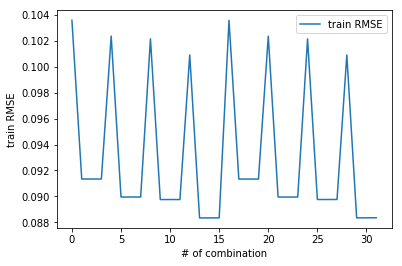

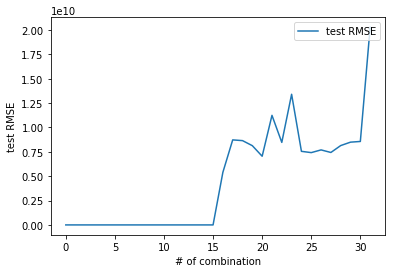

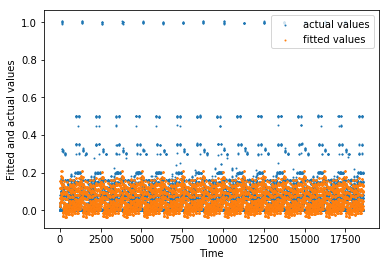

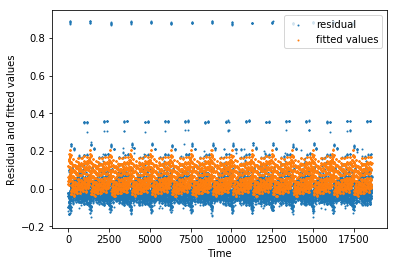

In [8]:
# (a) iv
from sklearn.preprocessing import OneHotEncoder

data = pd.read_csv('network_backup_dataset.csv')
data = data.replace({'Day of Week': {'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6, 'Sunday':7}})
data = data.replace({'Work-Flow-ID': {'work_flow_0':0, 'work_flow_1':1, 'work_flow_2':2, 'work_flow_3':3, 'work_flow_4':4}})
data = data.replace({'File Name': {'File_0':0, 'File_1':1, 'File_2':2, 'File_3':3, 'File_4':4, 'File_5':5, 'File_6':6, 'File_7':7,
                                   'File_8':8, 'File_9':9, 'File_10':10, 'File_11':11, 'File_12':12, 'File_13':13, 'File_14':14,
                                   'File_15':15, 'File_16':16, 'File_17':17, 'File_18':18, 'File_19':19, 'File_20':20, 'File_21':21, 
                                   'File_22':22, 'File_23':23, 'File_24':24, 'File_25':25, 'File_26':26, 'File_27':27, 'File_28':28,
                                   'File_29':29}})
# X = data[['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']]
y = data['Size of Backup (GB)']

a1 = OneHotEncoder(sparse = False).fit_transform(data[['Week #']])
a2 = OneHotEncoder(sparse = False).fit_transform(data[['Day of Week']])
a3 = OneHotEncoder(sparse = False).fit_transform(data[['Backup Start Time - Hour of Day']])
a4 = OneHotEncoder(sparse = False).fit_transform(data[['Work-Flow-ID']])
a5 = OneHotEncoder(sparse = False).fit_transform(data[['File Name']])

train_RMSE_rec = []
test_RMSE_rec = []

coef = {}

def calculate_RMSE(X, y):
    num_folds = 10
    X_folds = np.array_split(X, num_folds, axis = 0)
    y_folds = np.array_split(y, num_folds)

    train_RMSE = 0
    test_RMSE = 0
    for i in np.arange(10):
        X_train = np.vstack(X_folds[:i] + X_folds[i+1:]) 
        X_test = X_folds[i]
        y_train = np.hstack(y_folds[:i] + y_folds[i+1:]) 
        y_test = y_folds[i]
        lr = linear_model.LinearRegression()
        lr.fit(X_train, y_train)
        y_train_pred = lr.predict(X_train)
        y_test_pred = lr.predict(X_test)

        train_RMSE += mean_squared_error(y_train, y_train_pred)
        test_RMSE += mean_squared_error(y_test, y_test_pred)
    train_RMSE = np.sqrt(train_RMSE/num_folds)
    test_RMSE = np.sqrt(test_RMSE/num_folds)

    print("Training RMSE: %.5f" % train_RMSE)
    print("Testing RMSE: %.5f" % test_RMSE)

    return train_RMSE, test_RMSE

i = 1    
for each_a1 in (data[['Week #']], a1):
    for each_a2 in (data[['Day of Week']], a2):
        for each_a3 in (data[['Backup Start Time - Hour of Day']], a3):
            for each_a4 in (data[['Work-Flow-ID']], a4):
                for each_a5 in (data[['File Name']], a5):
                    print('Combination', i)
                    X = np.hstack((each_a1, each_a2, each_a3, each_a4, each_a5))
                    train, test = calculate_RMSE(X, y)
                    train_RMSE_rec.append(train)
                    test_RMSE_rec.append(test)
                    i+= 1    

fig, ax = plt.subplots()

ax.plot(np.arange(len(train_RMSE_rec)), train_RMSE_rec, label = 'train RMSE')
plt.legend(loc='upper right')
plt.xlabel('# of combination')
plt.ylabel('train RMSE')

fig, ax = plt.subplots()
ax.plot(np.arange(len(test_RMSE_rec)), test_RMSE_rec, label = 'test RMSE')
plt.legend(loc='upper right')
plt.xlabel('# of combination')
plt.ylabel('test RMSE')

plt.show()
    
# 0,0,0,0,0
# 0,1,1,1,0 -> (/, a2, a3, a4, /)
# 14=8+4+2

X = np.hstack((data[['Week #']], a2, a3, a4, data[['File Name']]))
lr = linear_model.LinearRegression()
y_pred = cross_val_predict(lr, X, y, cv = 10)
two_plots(y, y_pred)


#### v. Controlling ill-conditioning and over-fiting: You should have found obvious increases in test RMSE compared to training RMSE in some combinations, can you explain why this happens? Observe those fitted coefficients. To solve this problem, you can try the following regularizations with suitable parameters.
- It can be observed that in the previous problem, some of combination have similar small train and test RMSE while some combinations give small train RMSE but large test RMSE due to overfitting. When a model gives both small train RMSE and test RMSE, it means the model is good while if the train RMSE is pretty small but test RMSE is large, then it means there exists overfitting. 


- Since this large increase between train RMSE and test RMSE happens for the last half of combinations, then it is due to the one-hot-encoding on the first variable 'Week #'.


- For each combination, we can visualize their coeffiencts below. The coefficients and intercept for the 14th combination are:
> - Coefficients: [ 3.959e+09  3.959e+09  3.959e+09  3.959e+09  3.959e+09  3.959e+09
  3.959e+09  3.959e+09  3.959e+09  3.959e+09  3.959e+09  3.959e+09
  3.959e+09  3.959e+09  3.959e+09 -2.544e-03  1.382e-03 -2.230e+08
 -2.230e+08 -2.230e+08 -2.230e+08 -2.230e+08  3.550e-04]
> - Intercept: 3736167244.86856


- To avoid this overfitting from happening, in this problem, we explore different regularizers.


> -  Ridge Regularizer: Using *ridge_model*:
>> - Train RMSE is: 0.0893833096728555
>> - Test RMSE is: 0.07848342890320935
>> - Optimal $\alpha$ is: 10
>> - OPtimal coefficients are: [ 5.773e-05  3.934e-02 -1.237e-02 -2.050e-02 -5.784e-03 -5.429e-03  3.281e-03  1.467e-03 -2.050e-02 -2.087e-02  8.322e-03  3.365e-02 -2.075e-03  1.482e-03  2.693e-03  4.272e-02  4.181e-02  4.210e-02
  4.371e-02  4.200e-02  4.284e-02 -1.137e-02 -1.261e-02 -8.694e-03 -1.013e-02 -1.177e-02 -1.050e-02 -4.000e-02 -4.147e-02 -3.957e-02 -3.996e-02 -3.791e-02 -3.930e-02 -5.875e-02 -5.877e-02 -5.833e-02 -5.840e-02 -5.892e-02 -5.859e-02  6.734e-02  6.685e-02  6.632e-02  6.672e-02  6.580e-02  6.684e-02]
>> Optimal combination picked: 19


> -  Lasso Regularizer: Using *lasso_model*:
>> - Train RMSE is: 0.09122438974023302
>> - Test RMSE is: 0.07840715943921889
>> - Optimal $\alpha$ is: 0.001
>> - OPtimal coefficients are: [ 8.605e-06  3.757e-02 -1.383e-03 -1.042e-02 -0.000e+00 -0.000e+00  4.400e-04  0.000e+00  1.379e-03  4.523e-02 -0.000e+00 -2.319e-02 -3.999e-02  8.080e-02  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
>> Optimal combination picked: 21


> -  Elastic Net Regularizer: Using *enet_model*:
>> - Train RMSE is: 0.09169741183431646
>> - Test RMSE is: 0.07529424834457044
>> - Optimal $\alpha$ is: 0.01
>> - Optimal l1_ratio is: 0.1
>> - OPtimal coefficients are: [-0.000e+00  0.000e+00  0.000e+00 -0.000e+00  0.000e+00 -0.000e+00 -0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00  3.625e-02 -1.702e-03 -9.873e-03 -0.000e+00 -0.000e+00  0.000e+00  0.000e+00  1.379e-03  4.070e-02 -0.000e+00 -2.402e-02 -3.988e-02  7.473e-02 -6.499e-05]
>> Optimal combination picked: 6


- The train RMSE for original combination (14th combination) without doing regularization is 0.8834 and the test RMSE is 0.8850. It can be seen that after performing different regularization methods, different combinations will be picked up. However, one thing in common is that after regularization, each model will give smaller train RMSE and test RMSE.



In [9]:
# (a) v
# print(coef)
RMSE_rec = []
for each_a1 in (a1,  data[['Week #']]):
    for each_a2 in (a2,  data[['Day of Week']]):
        for each_a3 in (a3, data[['Backup Start Time - Hour of Day']]):
            for each_a4 in (a4, data[['Work-Flow-ID']]):
                for each_a5 in (a5, data[['File Name']]):
                    X = np.hstack((each_a1, each_a2, each_a3, each_a4, each_a5))
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.1, random_state = 0)
                    lr = linear_model.LinearRegression()
                    lr.fit(X_train, y_train)
                    y_predict = cross_val_predict(lr, X, y, cv = 10)
                    RMSE =  np.sqrt(mean_squared_error(y, y_predict))
                    RMSE_rec.append(RMSE)
                    print(lr.coef_)
                    print(lr.intercept_)

[ 1.004e+10  1.004e+10  1.004e+10  1.004e+10  1.004e+10  1.004e+10
  1.004e+10  1.004e+10  1.004e+10  1.004e+10  1.004e+10  1.004e+10
  1.004e+10  1.004e+10  1.004e+10  5.034e+09  5.034e+09  5.034e+09
  5.034e+09  5.034e+09  5.034e+09  5.034e+09  1.393e+11  1.393e+11
  1.393e+11  1.393e+11  1.393e+11  1.393e+11  8.024e+11  4.081e+11
 -4.337e+10  5.244e+11 -1.734e+11 -3.419e+11 -3.419e+11 -3.419e+11
 -3.419e+11 -3.419e+11 -3.419e+11  5.242e+10  5.242e+10  5.242e+10
  5.242e+10  5.242e+10  5.242e+10  5.039e+11  5.039e+11  5.039e+11
  5.039e+11  5.039e+11  5.039e+11 -6.386e+10 -6.386e+10 -6.386e+10
 -6.386e+10 -6.386e+10 -6.386e+10  6.339e+11  6.339e+11  6.339e+11
  6.339e+11  6.339e+11  6.339e+11]
-614898673905.4998
[ 7.900e+09  7.900e+09  7.900e+09  7.900e+09  7.900e+09  7.900e+09
  7.900e+09  7.900e+09  7.900e+09  7.900e+09  7.900e+09  7.900e+09
  7.900e+09  7.900e+09  7.900e+09  3.597e+09  3.597e+09  3.597e+09
  3.597e+09  3.597e+09  3.597e+09  3.597e+09  1.130e+11  1.130e+11
  1.130e

[-1.207e-05 -2.910e+10 -2.910e+10 -2.910e+10 -2.910e+10 -2.910e+10
 -2.910e+10 -2.910e+10  9.915e+08  9.915e+08  9.915e+08  9.915e+08
  9.915e+08  9.915e+08 -6.612e+07 -2.493e+08 -2.493e+08 -2.493e+08
 -2.493e+08 -2.493e+08 -2.493e+08 -1.832e+08 -1.832e+08 -1.832e+08
 -1.832e+08 -1.832e+08 -1.832e+08 -1.170e+08 -1.170e+08 -1.170e+08
 -1.170e+08 -1.170e+08 -1.170e+08 -5.092e+07 -5.092e+07 -5.092e+07
 -5.092e+07 -5.092e+07 -5.092e+07  1.520e+07  1.520e+07  1.520e+07
  1.520e+07  1.520e+07  1.520e+07]
28358110213.274746
[-3.791e-05 -4.530e+10 -4.530e+10 -4.530e+10 -4.530e+10 -4.530e+10
 -4.530e+10 -4.530e+10  1.033e+09  1.033e+09  1.033e+09  1.033e+09
  1.033e+09  1.033e+09 -3.052e-04  5.073e-04]
44264053085.968155
[-3.884e-06 -2.425e+10 -2.425e+10 -2.425e+10 -2.425e+10 -2.425e+10
 -2.425e+10 -2.425e+10  1.386e-03 -1.637e+08  2.360e+08  1.334e+08
 -7.558e+08 -6.866e+08 -1.096e+08 -1.096e+08 -1.096e+08 -1.096e+08
 -1.096e+08 -1.096e+08 -5.092e+08 -5.092e+08 -5.092e+08 -5.092e+08
 -5.092e+0

Smallest train RMSE is  0.0893833096728555
Smallest test RMSE is  0.07848342890320935
optimal alpha:  10.0
optimal coefficients:  [ 5.773e-05  3.934e-02 -1.237e-02 -2.050e-02 -5.784e-03 -5.429e-03
  3.281e-03  1.467e-03 -2.050e-02 -2.087e-02  8.322e-03  3.365e-02
 -2.075e-03  1.482e-03  2.693e-03  4.272e-02  4.181e-02  4.210e-02
  4.371e-02  4.200e-02  4.284e-02 -1.137e-02 -1.261e-02 -8.694e-03
 -1.013e-02 -1.177e-02 -1.050e-02 -4.000e-02 -4.147e-02 -3.957e-02
 -3.996e-02 -3.791e-02 -3.930e-02 -5.875e-02 -5.877e-02 -5.833e-02
 -5.840e-02 -5.892e-02 -5.859e-02  6.734e-02  6.685e-02  6.632e-02
  6.672e-02  6.580e-02  6.684e-02]
19


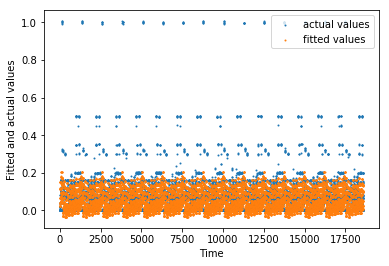

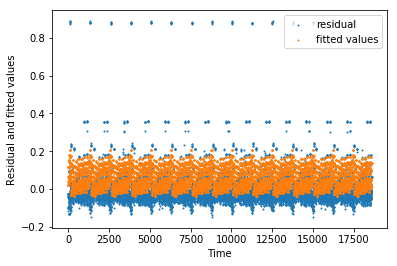

In [10]:
# ridge regularizer
y = data['Size of Backup (GB)']

test_RMSE_record = []
smallest_test_RMSE = 100
best_model = None

i = 1
for each_a1 in (a1,  data[['Week #']]):
    for each_a2 in (a2,  data[['Day of Week']]):
        for each_a3 in (a3, data[['Backup Start Time - Hour of Day']]):
            for each_a4 in (a4, data[['Work-Flow-ID']]):
                for each_a5 in (a5, data[['File Name']]):
                    X = np.hstack((each_a1, each_a2, each_a3, each_a4, each_a5))
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
                    ridge_model = linear_model.RidgeCV(cv = 10)
                    ridge_model.fit(X_train, y_train)
                    y_test_pred = ridge_model.predict(X_test)
                    test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))
                    test_RMSE_record.append(test_RMSE)
                    if test_RMSE < smallest_test_RMSE:
                        smallest_test_RMSE = test_RMSE
                        best_model = ridge_model
                        y_pred = best_model.predict(X)
                        y_train_pred = best_model.predict(X_train)
                        smallest_train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
                        data_chosen = (each_a1, each_a2, each_a3, each_a4, each_a5)
                        model_index = i     
                    i += 1
                    
print('Smallest train RMSE is ', smallest_train_RMSE)                   
print('Smallest test RMSE is ', smallest_test_RMSE)                        
print ("optimal alpha: ", best_model.alpha_)
print ("optimal coefficients: ", best_model.coef_)
# print(data_chosen)
print(model_index)

# y_test_pred = best_model.predict(X_test)
two_plots(y, y_pred)

Smallest train RMSE is  0.09122438974023302
Smallest test RMSE is  0.07840715943921889
optimal alpha:  0.001
optimal coefficients:  [ 8.605e-06  3.757e-02 -1.383e-03 -1.042e-02 -0.000e+00 -0.000e+00
  4.400e-04  0.000e+00  1.379e-03  4.523e-02 -0.000e+00 -2.319e-02
 -3.999e-02  8.080e-02  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00  0.000e+00  0.000e+00 -0.000e+00 -0.000e+00
 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00
 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00 -0.000e+00
 -0.000e+00 -0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
  0.000e+00  0.000e+00]
21


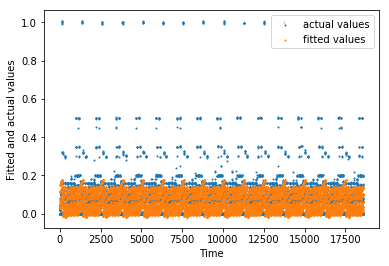

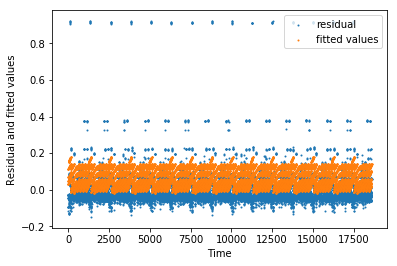

In [11]:
# lasso regularizer
y = data['Size of Backup (GB)']

test_RMSE_record = []
smallest_test_RMSE = 100
best_model = None

i = 1
for each_a1 in (a1,  data[['Week #']]):
    for each_a2 in (a2,  data[['Day of Week']]):
        for each_a3 in (a3, data[['Backup Start Time - Hour of Day']]):
            for each_a4 in (a4, data[['Work-Flow-ID']]):
                for each_a5 in (a5, data[['File Name']]):
                    X = np.hstack((each_a1, each_a2, each_a3, each_a4, each_a5))
                    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
                    lasso_model = linear_model.LassoCV(alphas = [0.1, 0.01, 0.001], cv = 10)
                    lasso_model.fit(X_train, y_train)
                    y_test_pred = lasso_model.predict(X_test)
                    test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))
                    test_RMSE_record.append(test_RMSE)
                    if test_RMSE < smallest_test_RMSE:
                        smallest_test_RMSE = test_RMSE
                        best_model = lasso_model
                        y_train_pred = best_model.predict(X_train)
                        smallest_train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
                        y_pred = best_model.predict(X)
                        data_chosen = (each_a1, each_a2, each_a3, each_a4, each_a5)
                        model_index = i     
                    i += 1
                    
print('Smallest train RMSE is ', smallest_train_RMSE)                   
print('Smallest test RMSE is ', smallest_test_RMSE)                          
print ("optimal alpha: ", best_model.alpha_)
print ("optimal coefficients: ", best_model.coef_)
# print(data_chosen)
print(model_index)

# y_test_pred = best_model.predict(X_test)
two_plots(y, y_pred)


Smallest train RMSE is  0.09169741183431646
Smallest test RMSE is  0.07529424834457044
optimal coefficients:  [-0.000e+00  0.000e+00  0.000e+00 -0.000e+00  0.000e+00 -0.000e+00
 -0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
 -0.000e+00 -0.000e+00 -0.000e+00  3.625e-02 -1.702e-03 -9.873e-03
 -0.000e+00 -0.000e+00  0.000e+00  0.000e+00  1.379e-03  4.070e-02
 -0.000e+00 -2.402e-02 -3.988e-02  7.473e-02 -6.499e-05]
0.01
0.1
6


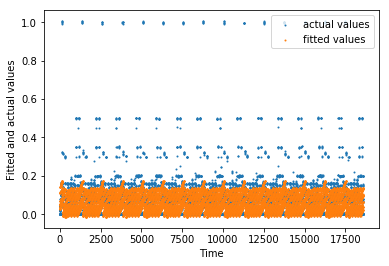

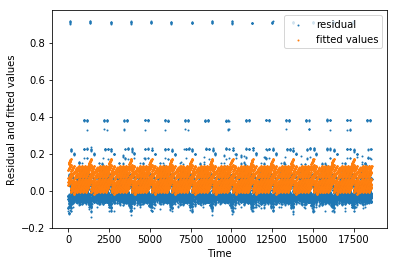

In [12]:
# elastic net regularizer
# alphas = np.logspace(-5, 1, 60) 
alphas = [0.01, 0.1, 1, 10]
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]    
y = data['Size of Backup (GB)']

test_RMSE_record = []
smallest_test_RMSE = 100
best_model = None

i = 1
for each_a1 in (a1,  data[['Week #']]):
    for each_a2 in (a2,  data[['Day of Week']]):
        for each_a3 in (a3, data[['Backup Start Time - Hour of Day']]):
            for each_a4 in (a4, data[['Work-Flow-ID']]):
                for each_a5 in (a5, data[['File Name']]):
                    for alpha in alphas: 
                        for l1 in l1_ratios:
                            X = np.hstack((each_a1, each_a2, each_a3, each_a4, each_a5))
                            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
                            enet_model = linear_model.ElasticNet(alpha, l1_ratio = l1)
                            enet_model.fit(X_train, y_train)
                            y_test_pred = enet_model.predict(X_test)
                            test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))
                            test_RMSE_record.append(test_RMSE)
                            if test_RMSE < smallest_test_RMSE:
                                smallest_test_RMSE = test_RMSE
                                best_model = enet_model
                                y_pred = best_model.predict(X)
                                y_train_pred = best_model.predict(X_train)
                                smallest_train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
                                data_chosen = (each_a1, each_a2, each_a3, each_a4, each_a5)
                                model_index = i
                                best_alpha = alpha
                                best_l1_ratio = l1
                    i += 1
                    
print('Smallest train RMSE is ', smallest_train_RMSE)                   
print('Smallest test RMSE is ', smallest_test_RMSE)                         
# print ("optimal alpha: ", best_model.alpha_)
print ("optimal coefficients: ", best_model.coef_)
# print(data_chosen)
print(best_alpha)
print(best_l1_ratio)
print(model_index)

# y_test_pred = best_model.predict(X_test)
two_plots(y, y_pred)

### (b) Use a random forest regression model for this same task.

#### i. Report Training and average Test RMSE from 10 fold cross validation (sum up each fold’s square error, divide by total number of data then take square root) and Out Of Bag error you get from this initial model.
- Training RMSE: 0.0606
- Testing RMSE: 0.0604
- Out of bag error: 0.3371
- Two plots showing fitted values and true values vs data points and fitted values and residual vs data points are shown below.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

Training RMSE: 0.0602
Testing RMSE: 0.0604
Out of bag error: 0.3371


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

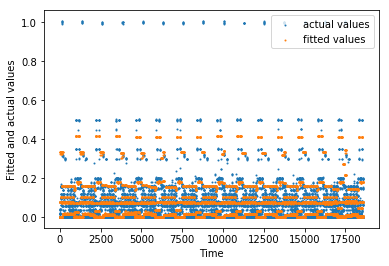

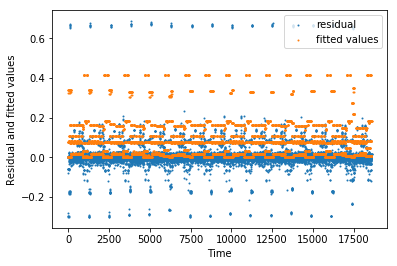

In [13]:
# (b) Use a random forest regression model for this same task
#  i.
from sklearn.ensemble import RandomForestRegressor
X = data[['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']]
y = data['Size of Backup (GB)']
init_num_trees = 20
init_depth_each_tree = 4
Boostrap = True
init_max_num_features = 5  
num_folds = 10    
X_folds = np.array_split(X, num_folds, axis = 0)
y_folds = np.array_split(y, num_folds)

train_RMSE = 0
test_RMSE = 0
out_of_bag_error = 0
for i in np.arange(10):
    X_train = np.vstack(X_folds[:i] + X_folds[i+1:]) 
    X_test = X_folds[i]
    y_train = np.hstack(y_folds[:i] + y_folds[i+1:]) 
    y_test = y_folds[i]
    rf = RandomForestRegressor(n_estimators = init_num_trees, max_features = init_max_num_features, \
                               max_depth = init_depth_each_tree, bootstrap = Boostrap, oob_score = True)
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)

    train_RMSE += mean_squared_error(y_train, y_train_pred)
    test_RMSE += mean_squared_error(y_test, y_test_pred)
    out_of_bag_error += (1-rf.oob_score_)
    
train_RMSE = np.sqrt(train_RMSE/num_folds)
test_RMSE = np.sqrt(test_RMSE/num_folds)
out_of_bag_error = out_of_bag_error/num_folds

print("Training RMSE: %.4f" % train_RMSE)
print("Testing RMSE: %.4f" % test_RMSE)
print("Out of bag error: %.4f" % out_of_bag_error)

y_pred = cross_val_predict(rf, X, y, cv = num_folds)
two_plots(y, y_pred)

#### ii. Sweep over number of trees from 1 to 200 and maximum number of features from 1 to 5, plot figure 1 for out of bag error(y axis) against number of trees(x axis), figure 2 for average Test-RMSE(y axis) against number of trees(x axis).
- Figure 1 is out of bag error(y axis) against number of trees(x axis)
- Figure 2 is average Test-RMSE(y axis) against number of trees(x axis)
- Figure 3 is fitted values and true values vs data points 
- Figure 4 is fitted values and residual vs data points
- Train RMSE for the best random forest regressor is 0.059573259904730246
- Test RMSE for the best random forest regressorl is 0.059671171272995906

- It can be observed that as the num of trees increases, both out-of-bag-error and average test-RMSE are decreasing and becoming steady after num of trees equals 20. Also, the larger the number of features is, the smaller the out-of-bag-error and average test-RMSE. These two observations are reasonable since that more trees can help random forest to split the data more separately and more features can help decide the split more wisely. However, as number of trees or number of features go really large, there be little help on dividing splits since our model is not that complicated and do not need so many nodes.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

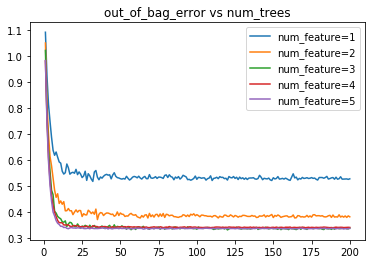

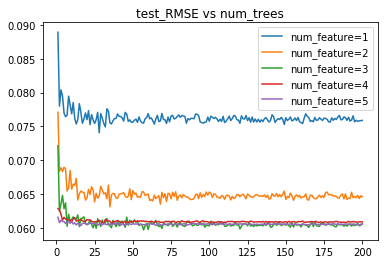

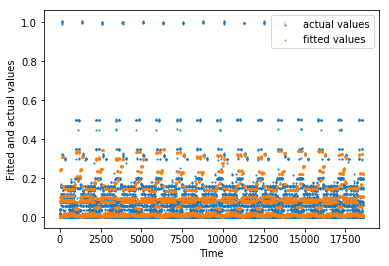

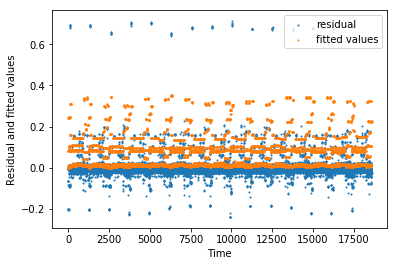

Train RMSE for best model is  0.059573259904730246
Test RMSE for best model is  0.059671171272995906


In [14]:
# (b) ii.
X = data[['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']]
y = data['Size of Backup (GB)']
X = np.array(X)
y = np.array(y)
init_depth_each_tree = 4
Boostrap = True
num_trees = np.arange(1,201)
num_features = np.arange(1,6)
train_RMSE_record = []
test_RMSE_record = []
out_of_bag_error_record = []
best_test_RMSE = 100
best_rf_depth_4 = None 
num_folds = 10    
X_folds = np.array_split(X, num_folds, axis = 0)
y_folds = np.array_split(y, num_folds)
for num_feature in num_features:
    for num_tree in num_trees:
        train_RMSE = 0
        test_RMSE = 0
        out_of_bag_error = 0
        for i in np.arange(10):
            X_train = np.vstack(X_folds[:i] + X_folds[i+1:]) 
            X_test = X_folds[i]
            y_train = np.hstack(y_folds[:i] + y_folds[i+1:]) 
            y_test = y_folds[i]
            rf = RandomForestRegressor(n_estimators = num_tree, max_features = num_feature, \
                                       max_depth = init_depth_each_tree, bootstrap = Boostrap, oob_score = True)
            rf.fit(X_train, y_train)
            y_train_pred = rf.predict(X_train)
            y_test_pred = rf.predict(X_test)

            train_RMSE += mean_squared_error(y_train, y_train_pred)
            test_RMSE += mean_squared_error(y_test, y_test_pred)
            out_of_bag_error += (1-rf.oob_score_)

        train_RMSE = np.sqrt(train_RMSE/num_folds)
        test_RMSE = np.sqrt(test_RMSE/num_folds)
        out_of_bag_error = out_of_bag_error/num_folds
        train_RMSE_record.append(train_RMSE)
        test_RMSE_record.append(test_RMSE)
        out_of_bag_error_record.append(out_of_bag_error)
        if test_RMSE < best_test_RMSE:
            best_test_RMSE = test_RMSE
            best_train_RMSE = train_RMSE
            best_rf_depth_4 = rf
            

test_RMSE_record_1 = test_RMSE_record[:200]
out_of_bag_error_record_1 = out_of_bag_error_record[:200]
test_RMSE_record_2 = test_RMSE_record[200:400]
out_of_bag_error_record_2 = out_of_bag_error_record[200:400]
test_RMSE_record_3 = test_RMSE_record[400:600]
out_of_bag_error_record_3 = out_of_bag_error_record[400:600]
test_RMSE_record_4 = test_RMSE_record[600:800]
out_of_bag_error_record_4 = out_of_bag_error_record[600:800]
test_RMSE_record_5 = test_RMSE_record[800:]
out_of_bag_error_record_5 = out_of_bag_error_record[800:1000]

plt.figure()
plt.plot(num_trees, out_of_bag_error_record_1, label = 'num_feature=1')
plt.plot(num_trees, out_of_bag_error_record_2, label = 'num_feature=2')
plt.plot(num_trees, out_of_bag_error_record_3, label = 'num_feature=3')
plt.plot(num_trees, out_of_bag_error_record_4, label = 'num_feature=4')
plt.plot(num_trees, out_of_bag_error_record_5, label = 'num_feature=5')
plt.legend(loc='upper right')
plt.title('out_of_bag_error vs num_trees')

plt.figure()
plt.plot(num_trees, test_RMSE_record_1, label = 'num_feature=1')
plt.plot(num_trees, test_RMSE_record_2, label = 'num_feature=2')
plt.plot(num_trees, test_RMSE_record_3, label = 'num_feature=3')
plt.plot(num_trees, test_RMSE_record_4, label = 'num_feature=4')
plt.plot(num_trees, test_RMSE_record_5, label = 'num_feature=5')
plt.legend(loc='upper right')
plt.title('test_RMSE vs num_trees')
plt.show()

y_pred = cross_val_predict(best_rf_depth_4, X, y, cv = 10)
two_plots(y, y_pred)
print('Train RMSE for best model is ', best_train_RMSE)
print('Test RMSE for best model is ', best_test_RMSE)

In [30]:
print(best_rf_depth_4)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=57, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)


#### iii. Pick another parameter you want to experiment on. Plot similar figure 1 and figure 2 as above. What parameters would you pick to achieve the best performance?
- We here pickup the *num_depth* and search from 1 to 10 with a depth of 2 and then plot similar plots as last question. The test RMSE is smallest when num_trees = 200 and num_depth = 9
- Figure 1 is out of bag error(y axis) against number of trees(x axis)
- Figure 2 is average Test-RMSE(y axis) against number of trees(x axis)
- Figure 3 is fitted values and true values vs data points 
- Figure 4 is fitted values and residual vs data points
- Train RMSE for the best random forest regressor is 0.011551976054799847
- Test RMSE for the best random forest regressorl is 0.017318195754580646


- It can be found that with the increase of number of depth, the out-of-bag-error and average test RMSE can decrease. It means the random forest is becoming deeper and deeper and can make more thoroguh splits.


1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

3


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

5


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

7


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

9


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs d

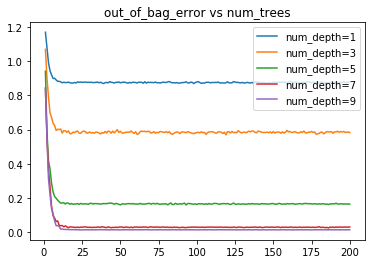

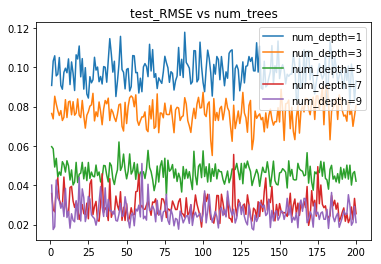

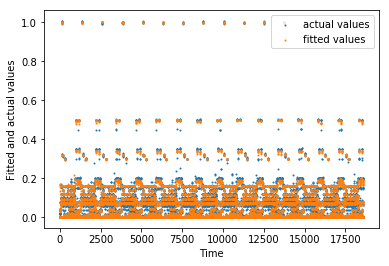

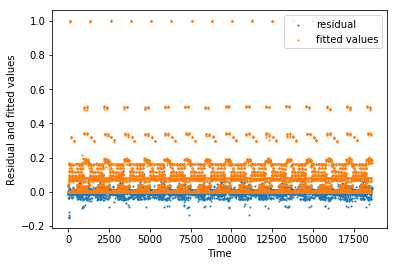

Train RMSE for best model is  0.011551976054799847
Test RMSE for best model is  0.017318195754580646


In [15]:
# (b) iii.
X = data[['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']]
y = data['Size of Backup (GB)']

init_depth_each_tree = 4
Boostrap = True
num_trees = np.arange(1,201)
num_feature = 5
# num_features = np.arange(1,6)
num_depths = np.arange(1, 10, 2)

test_RMSE_record = []
out_of_bag_error_record = []
test_RMSE_min = 100
best_model = None

for num_dep in num_depths:
    print(num_dep)
    for num_tree in num_trees:
#         print(num_dep, num_tree)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
        rf = RandomForestRegressor(n_estimators = num_tree, max_features = num_feature, \
                                   max_depth = num_dep, bootstrap = Boostrap, oob_score = True)
        rf.fit(X_train, y_train)
        y_test_pred = cross_val_predict(rf, X_test, y_test)
        test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_RMSE_record.append(test_RMSE)
        out_of_bag_error = 1-rf.oob_score_
        out_of_bag_error_record.append(out_of_bag_error)
        if test_RMSE < test_RMSE_min:
            test_RMSE_min = test_RMSE
            best_model = rf
            y_train_pred = best_model.predict(X_train)
            train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))

        
test_RMSE_record_1 = test_RMSE_record[:200]
out_of_bag_error_record_1 = out_of_bag_error_record[:200]
test_RMSE_record_2 = test_RMSE_record[200:400]
out_of_bag_error_record_2 = out_of_bag_error_record[200:400]
test_RMSE_record_3 = test_RMSE_record[400:600]
out_of_bag_error_record_3 = out_of_bag_error_record[400:600]
test_RMSE_record_4 = test_RMSE_record[600:800]
out_of_bag_error_record_4 = out_of_bag_error_record[600:800]
test_RMSE_record_5 = test_RMSE_record[800:]
out_of_bag_error_record_5 = out_of_bag_error_record[800:1000]

plt.figure()
plt.plot(num_trees, out_of_bag_error_record_1, label = 'num_depth=1')
plt.plot(num_trees, out_of_bag_error_record_2, label = 'num_depth=3')
plt.plot(num_trees, out_of_bag_error_record_3, label = 'num_depth=5')
plt.plot(num_trees, out_of_bag_error_record_4, label = 'num_depth=7')
plt.plot(num_trees, out_of_bag_error_record_5, label = 'num_depth=9')
plt.legend(loc='upper right')
plt.title('out_of_bag_error vs num_trees')

plt.figure()
plt.plot(num_trees, test_RMSE_record_1, label = 'num_depth=1')
plt.plot(num_trees, test_RMSE_record_2, label = 'num_depth=3')
plt.plot(num_trees, test_RMSE_record_3, label = 'num_depth=5')
plt.plot(num_trees, test_RMSE_record_4, label = 'num_depth=7')
plt.plot(num_trees, test_RMSE_record_5, label = 'num_depth=9')
plt.legend(loc='upper right')
plt.title('test_RMSE vs num_trees')
plt.show()        
        
y_pred = cross_val_predict(best_model, X, y, cv = 10)
two_plots(y, y_pred)
print('Train RMSE for best model is ', train_RMSE)
print('Test RMSE for best model is ', test_RMSE_min)

#### iv. Report the feature importances you got from the best random forest regression you find.
- By using *feature_importances_*
- Then we can conclude the feature_importance in a table

|feature idx|1|4|3|2|0|
|-|-|-|-|-|
|feature name|Day of Week|File Name|Work-Flow-ID|Backup Start Time - Hour of Day|Week #|
|feature importance|0.332905|0.275288|0.268168|0.123369|0.000270|

Feature importance got from the best random forest regression is  [0.002 0.203 0.394 0.18  0.221]
0.017318195754580646
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=4,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=57, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)
Feature ranking:
1. feature 1 (0.306367)
2. feature 4 (0.300115)
3. feature 3 (0.260081)
4. feature 2 (0.133042)
5. feature 0 (0.000396)


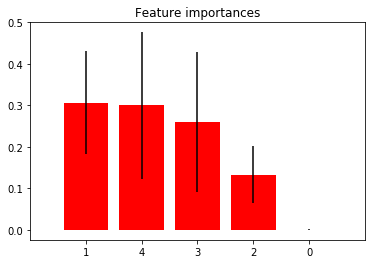

In [29]:
# (b) iv. Report the feature importances you got from the best random forest regression you find.
print('Feature importance got from the best random forest regression is ', best_model.feature_importances_)
print(test_RMSE_min)
print(best_rf_depth_4)

best_rf_depth_4.fit(X, y)
importances = best_rf_depth_4.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rf_depth_4.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

#### v. Visualize your decision trees. Pick any tree (estimator) in best random forest (with max depth=4) and plot its structure, which is the root node in this decision tree? Is it the most important feature according to the feature importance reported by the regressor?
- By using export_graphviz provided by sklearn and the best random forest we found previously, we can plot its structure below. The root node is X[1] and it is actually the most important feature according to feature importance. It is reasonable that since it is the most important one, when the decision tree is making first decision, it will look at this feature 1.

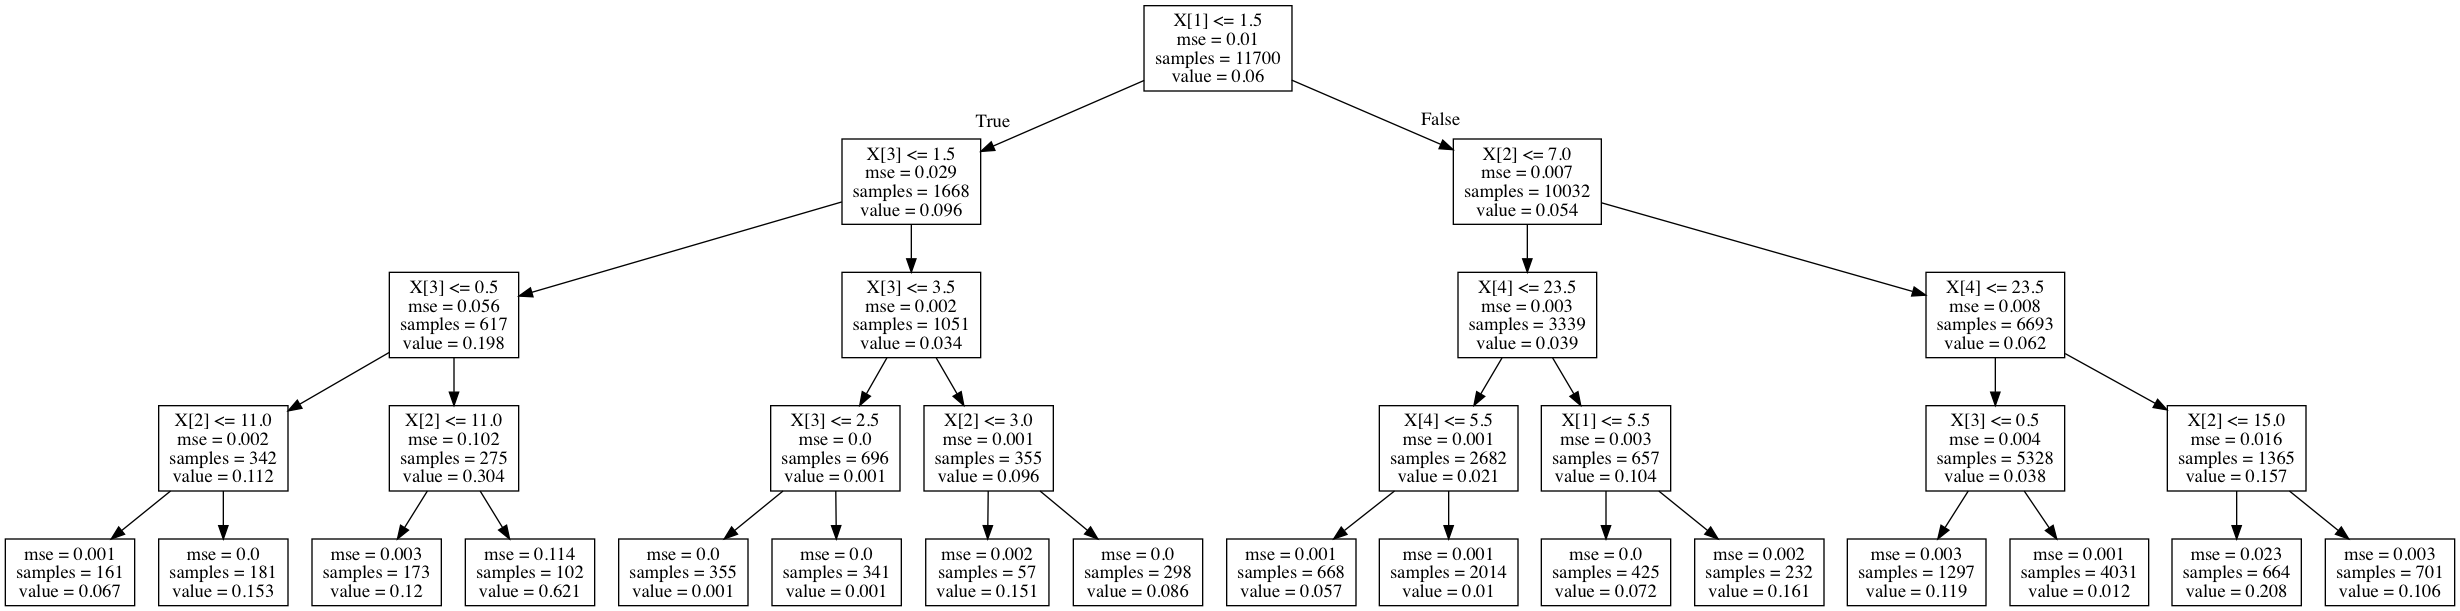

In [31]:
# (b) v. Visualize your decision trees. Pick any tree (estimator) in best random forest 
# (with max depth=4) and plot its structure, which is the root node in this decision tree?
# Is it the most important feature according to the feature importance reported by the regressor?

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
# import pydotplus
# from sklearn.tree import DecisionTreeRegressor

X = data[['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']]
y = data['Size of Backup (GB)']

best_modell = RandomForestRegressor(max_depth=4, max_features=3) 
best_modell.fit(np.array(X), np.array(y))
dot_data = StringIO()
estimator = best_modell.estimators_[3]
export_graphviz(estimator, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
# graph.write_png("best_model.png")



### (c) Now use a neural network regression model (one hidden layer) with all features one-hot encoded. 
- As asked, we grid search the combination of Number of hidden units from 10 to 200 with a depth of 10 and the Activity Function(relu, logistic, tanh) with all features one-hot encoded.

- Figure 1: Test-RMSE as a function of the number of hidden units for different activity functions. 
- Figure 2: Fitted values and true values vs data points for the best combination.
- Figure 3: Fitted values and residual vs data points for the best combination.
- Number of hidden used in the best combination: 170
- Activation function used in the best combination: tanh
- Train RMSE: 0.09366204224331026
- Test RMSE: 0.03231785260100852


- There is no clear tendency indicating which combination leads to better performance that NN performs well overall on one-hot-encoded features. 

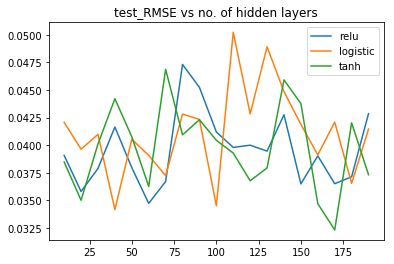

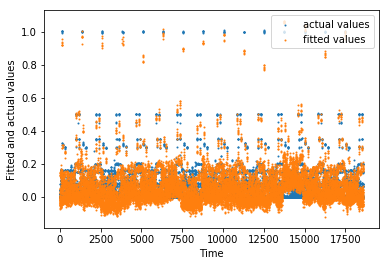

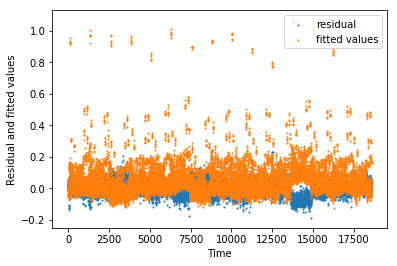

Train RMSE for best model is  0.09366204224331026
Test RMSE for best model is  0.03231785260100852
Num of hidden units in the best combination is:  170
Activation function used in the best combination:  tanh


In [20]:
# (c)
# Now use a neural network regression model (one hidden layer) with all features one-hot encoded. Parameters:
# • Number of hidden units
# • Activity Function(relu, logistic, tanh)
# Plot Test-RMSE as a function of the number of hidden units for different ac-
# tivity functions. Report the best combination.
from sklearn.neural_network import MLPRegressor

y = data['Size of Backup (GB)']

a1 = OneHotEncoder(sparse = False).fit_transform(data[['Week #']])
a2 = OneHotEncoder(sparse = False).fit_transform(data[['Day of Week']])
a3 = OneHotEncoder(sparse = False).fit_transform(data[['Backup Start Time - Hour of Day']])
a4 = OneHotEncoder(sparse = False).fit_transform(data[['Work-Flow-ID']])
a5 = OneHotEncoder(sparse = False).fit_transform(data[['File Name']])

best_combination = None
best_RMSE = 100
plt.figure()
X = np.hstack((a1, a2, a3, a4, a5))
for act_func in ['relu', 'logistic', 'tanh']:
    test_RMSE_record = []
    for num_hidden in np.arange(10,200,10):
        nn = MLPRegressor()
        y_predicted = cross_val_predict(nn, X, y, cv=10)
        test_RMSE = np.sqrt(mean_squared_error(y_predicted, y))
        test_RMSE_record.append(test_RMSE)
        if test_RMSE < best_RMSE:
            best_RMSE = test_RMSE
            best_combination = nn
            cur_act_func = act_func
            cur_num_hidden = num_hidden
            best_combination.fit(X_train, y_train)
            y_train_pred = best_combination.predict(X_train)
            train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
            
    plt.plot(list(np.arange(10,200,10)), test_RMSE_record, label = act_func)
plt.title("test_RMSE vs no. of hidden layers")
plt.legend(loc='upper right')
plt.show()

y_pred = cross_val_predict(best_combination, X, y, cv = 10)
two_plots(y, y_pred)
print('Train RMSE for best model is ', train_RMSE)
print('Test RMSE for best model is ', best_RMSE)
print('Num of hidden units in the best combination is: ', cur_num_hidden)
print('Activation function used in the best combination: ', cur_act_func)


### (d) Predict the backup size for each of the workflows separately

#### i. Using linear regression model. Explain if the fit is improved?
- In the following, we calculate train RMSE and test RMSE for each workflow and plot the required two figures for each workflow. We hereby report RMSE for each workflow.

||workflow_0|workflow_1|workflow_2|workflow_3|workflow_4|
|---|---|---|---|---|---|
|train RMSE|0.035835520779861095|0.14876603056260168|0.04290932063907724|0.007243878873882534|0.08592193679327194|
|test RMSE|0.035886970248931206|0.14891860201393803|0.043066905847879304|0.007260894242099694|0.08599061411565445|

- It can be seen that by performing linear regression on each workflow separately, it is better than to perform all the workflows collaboratively. This is because data in each workflow have their own similarities, and there exists great different among workflows so that the fit is improved in this question.

Train RMSE for workflow 0:  0.035835520779861095
Test RMSE for workflow 0:  0.035886970248931206


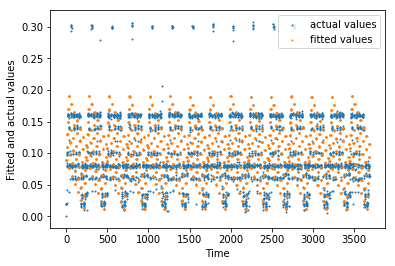

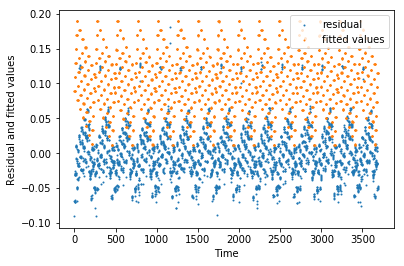

Train RMSE for workflow 1:  0.14876603056260168
Test RMSE for workflow 1:  0.14891860201393803


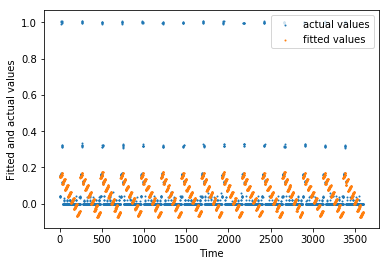

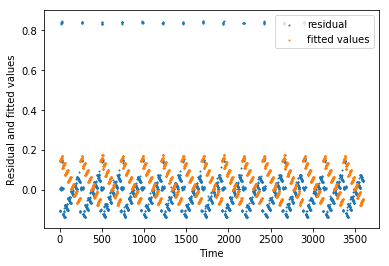

Train RMSE for workflow 2:  0.04290932063907724
Test RMSE for workflow 2:  0.043066905847879304


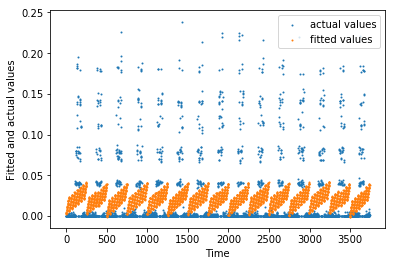

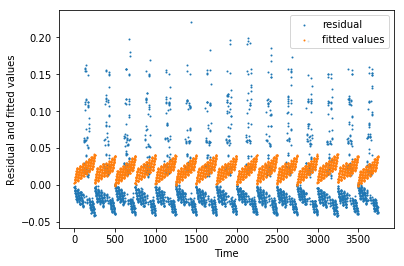

Train RMSE for workflow 3:  0.007243878873882534
Test RMSE for workflow 3:  0.007260894242099694


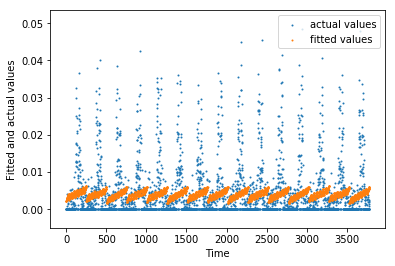

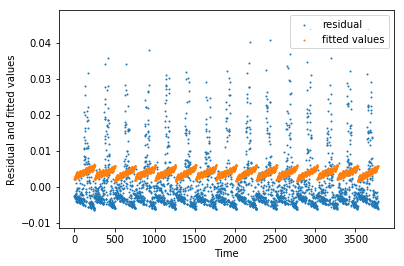

Train RMSE for workflow 4:  0.08592193679327194
Test RMSE for workflow 4:  0.08599061411565445


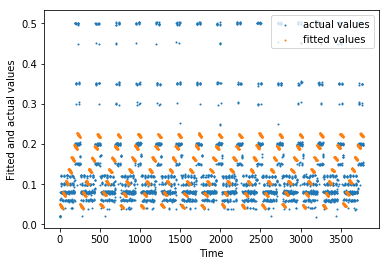

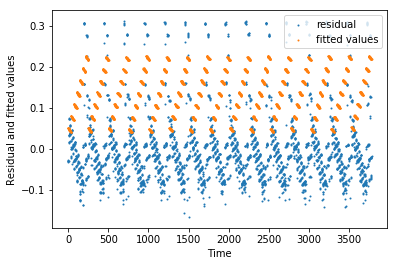

In [21]:
# (d) Predict the Backup size for each of the workflows separately.
# i. Using linear regression model. Explain if the fit is improved?
X = data[['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']]
y = data['Size of Backup (GB)']
X = np.array(X)
y = np.array(y)
# print(X[1])
X_0 = []
X_1 = []
X_2 = []
X_3 = []
X_4 = []

y_0 = []
y_1 = []
y_2 = []
y_3 = []
y_4 = []

for i in np.arange(X.shape[0]):
    if X[i][3] == 0:
        X_0.append(X[i])
        y_0.append(y[i])
    if X[i][3] == 1:
        X_1.append(X[i])
        y_1.append(y[i])
    if X[i][3] == 2:
        X_2.append(X[i])
        y_2.append(y[i])
    if X[i][3] == 3:
        X_3.append(X[i])
        y_3.append(y[i])
    if X[i][3] == 4:
        X_4.append(X[i])
        y_4.append(y[i])

X_0 = np.array(X_0)
# print(X_0)
X_1 = np.array(X_1)
X_2 = np.array(X_2)
X_3 = np.array(X_3)
X_4 = np.array(X_4)

y_0 = np.array(y_0)
y_1 = np.array(y_1)
y_2 = np.array(y_2)
y_3 = np.array(y_3)
y_4 = np.array(y_4)

# RMSE_rec = []
train_RMSE_0 = 0
train_RMSE_1 = 0
train_RMSE_2 = 0
train_RMSE_3 = 0
train_RMSE_4 = 0

test_RMSE_0 = 0
test_RMSE_1 = 0
test_RMSE_2 = 0
test_RMSE_3 = 0
test_RMSE_4 = 0


# Workflow 0
X_folds_0 = np.array_split(X_0, num_folds, axis = 0)
y_folds_0 = np.array_split(y_0, num_folds, axis = 0)
for j in np.arange(10):      
    X_train = np.vstack(X_folds_0[:j] + X_folds_0[j+1:]) 
    X_test = X_folds_0[j]
    y_train = np.hstack(y_folds_0[:j] + y_folds_0[j+1:]) 
    y_test = y_folds_0[j]
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    train_RMSE_0 += mean_squared_error(y_train, y_train_pred)
    test_RMSE_0 += mean_squared_error(y_test, y_test_pred)

train_RMSE_0 = np.sqrt(train_RMSE_0/num_folds)
test_RMSE_0 = np.sqrt(test_RMSE_0/num_folds)
print ("Train RMSE for workflow 0: ", train_RMSE_0)
print ("Test RMSE for workflow 0: ", test_RMSE_0)

y_predict_0 = cross_val_predict(lr, X_0, y_0, cv = 10)
two_plots(y_0, y_predict_0)

# Workflow 1
X_folds_1 = np.array_split(X_1, num_folds, axis = 0)
y_folds_1 = np.array_split(y_1, num_folds, axis = 0)
for j in np.arange(10):      
    X_train = np.vstack(X_folds_1[:j] + X_folds_1[j+1:]) 
    X_test = X_folds_1[j]
    y_train = np.hstack(y_folds_1[:j] + y_folds_1[j+1:]) 
    y_test = y_folds_1[j]
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    train_RMSE_1 += mean_squared_error(y_train, y_train_pred)
    test_RMSE_1 += mean_squared_error(y_test, y_test_pred)

train_RMSE_1 = np.sqrt(train_RMSE_1/num_folds)
test_RMSE_1 = np.sqrt(test_RMSE_1/num_folds)
print ("Train RMSE for workflow 1: ", train_RMSE_1)
print ("Test RMSE for workflow 1: ", test_RMSE_1)

y_predict_1 = cross_val_predict(lr, X_1, y_1, cv = 10)
two_plots(y_1, y_predict_1)

# Workflow 2
X_folds_2 = np.array_split(X_2, num_folds, axis = 0)
y_folds_2 = np.array_split(y_2, num_folds, axis = 0)
for j in np.arange(10):      
    X_train = np.vstack(X_folds_2[:j] + X_folds_2[j+1:]) 
    X_test = X_folds_2[j]
    y_train = np.hstack(y_folds_2[:j] + y_folds_2[j+1:]) 
    y_test = y_folds_2[j]
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    train_RMSE_2 += mean_squared_error(y_train, y_train_pred)
    test_RMSE_2 += mean_squared_error(y_test, y_test_pred)

train_RMSE_2 = np.sqrt(train_RMSE_2/num_folds)
test_RMSE_2 = np.sqrt(test_RMSE_2/num_folds)
print ("Train RMSE for workflow 2: ", train_RMSE_2)
print ("Test RMSE for workflow 2: ", test_RMSE_2)

y_predict_2 = cross_val_predict(lr, X_2, y_2, cv = 10)
two_plots(y_2, y_predict_2)


# Workflow 3
X_folds_3 = np.array_split(X_3, num_folds, axis = 0)
y_folds_3 = np.array_split(y_3, num_folds, axis = 0)
for j in np.arange(10):      
    X_train = np.vstack(X_folds_3[:j] + X_folds_3[j+1:]) 
    X_test = X_folds_3[j]
    y_train = np.hstack(y_folds_3[:j] + y_folds_3[j+1:]) 
    y_test = y_folds_3[j]
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    train_RMSE_3 += mean_squared_error(y_train, y_train_pred)
    test_RMSE_3 += mean_squared_error(y_test, y_test_pred)

train_RMSE_3 = np.sqrt(train_RMSE_3/num_folds)
test_RMSE_3 = np.sqrt(test_RMSE_3/num_folds)
print ("Train RMSE for workflow 3: ", train_RMSE_3)
print ("Test RMSE for workflow 3: ", test_RMSE_3)

y_predict_3 = cross_val_predict(lr, X_3, y_3, cv = 10)
two_plots(y_3, y_predict_3)


# Workflow 4
X_folds_4 = np.array_split(X_4, num_folds, axis = 0)
y_folds_4 = np.array_split(y_4, num_folds, axis = 0)
for j in np.arange(10):      
    X_train = np.vstack(X_folds_4[:j] + X_folds_4[j+1:]) 
    X_test = X_folds_4[j]
    y_train = np.hstack(y_folds_4[:j] + y_folds_4[j+1:]) 
    y_test = y_folds_4[j]
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    train_RMSE_4 += mean_squared_error(y_train, y_train_pred)
    test_RMSE_4 += mean_squared_error(y_test, y_test_pred)

train_RMSE_4 = np.sqrt(train_RMSE_4/num_folds)
test_RMSE_4 = np.sqrt(test_RMSE_4/num_folds)
print ("Train RMSE for workflow 4: ", train_RMSE_4)
print ("Test RMSE for workflow 4: ", test_RMSE_4)

y_predict_4 = cross_val_predict(lr, X_4, y_4, cv = 10)
two_plots(y_4, y_predict_4)



#### ii. # Try fitting a more complex regression function to your data. You can try a polynomial function of your variables. Try increasing the degree of the polynomial to improve your fit. Again, use a 10 fold cross validation to evaluate your results. Plot the average train and test RMSE of the trained model against the degree of the polynomial you use. Can you find a threshold on the degree of the fitted polynomial beyond which the generalization error of your model gets worse? Can you explain how cross validation helps controlling the complexity of your model?

- Polynomial function of the variables is performed by using *PolynomialFeatures* provided by sklearn.

- We try the degree of polynomials from 1 to 5 in this question, and the average train and test RMSE for each workflow are reported in the following table.

Workflow 0:

|degree|1|2|3|4|5|6|7|8|
|---|-------|----------|----------|----------|----------|---|---|---|
|train RMSE|0.035835520779861095|0.02951891509118551|0.02630954712453065|0.024962238121049172|0.018209437791093158|0.010376503987379326|0.009069607811939205|0.007958804095917777|
|test RMSE|0.035886970248931206|0.02954000920366244|0.02638753497794925|0.025150666805496432|0.01875477228019832|0.012865228404954373|0.011939859104153662|*0.017444888294886742*|


Workflow 1:

|degree|1|2|3|4|5|6|7|8|
|---|-------|----------|----------|----------|----------|---|---|---|
|train RMSE|0.14876603056260168|0.12984551865512522|0.11113444593103634|0.08939243683226872|0.06556258032152666|0.042486438474353294|0.020758575466296954|0.008112094032228803|
|test RMSE|0.14891860201393806|0.1301042348514586|0.11145942793582402|0.08962329201220455|0.06616528419597147|0.04300057355085209|0.022624624826212955|0.015338681048526152|

Workflow 2:

|degree|1|2|3|4|5|6|7|8|
|---|-------|----------|----------|----------|----------|---|---|---|
|train RMSE|0.04290932063907724|0.03846069142284416|0.03446961025670463|0.03182363633581566|0.025911127994652887|0.021627292114392033|0.020727054891286872|0.01932515908511564|
|test RMSE|0.043066905847879304|0.03887949046745007|0.03485191150461915|0.03283550323510874|0.026941022074034357|0.025336180820362535|*0.03087652276800132*|0.03988870890343819|

Workflow 3:

|degree|1|2|3|4|5|6|7|8|
|---|-------|----------|----------|----------|----------|---|---|---|
|train RMSE|0.0072438788738825345|0.006379974977708542|0.006023819909961968|0.005452823154339548|0.004902413173250664|0.0045885270041568825|0.004370966875411133|0.004249106224857203|
|test RMSE|0.006005352329101694|0.006739228398802911|0.005275346034029242|0.005920306483457248|0.00410106157628616|0.005407888471345822|0.0040513811995172315|0.005094792887471219|

Workflow 4:

|degree|1|2|3|4|5|6|7|8|
|---|-------|----------|----------|----------|----------|---|---|---|
|train RMSE|0.08592193679327194|0.069194466544322|0.0608619463182538|0.04894093562205807|0.03614644604872457|0.025961264049570124|0.020889595648082297|0.018406270278199258|
|test RMSE|0.08599061411565445|0.06934570046118899|0.0611133247825961|0.049573981867593014|0.03711447889605799|0.029764351014539493|0.026708438222516284|*0.03273386559390366*|

- From all above data, it can be found that train RMSE for best model is 0.004328779304072251 and test RMSE is 0.0040513811995172315.


- Figure 1: fitted values and actual values for each datapoint
- Figure 2: fitted values and residual for each datapoint
- We plot the Average train RMSE vs the degree of the polynomial for each workflow as Figure 3 and Average test RMSE vs the degree of the polynomial for each workflow as Figure 4.


- Polynomial features followed by linear regression on each workflow can give better results than before, which indicates our features are polynomial features but not linear features. 

- From both graph and statistics we get, we can find thresholds for each workflow which are in bold. For workflow 0, the threshold of degree is 8, the threshold of degree for workflow 2 is 7 and the threshold of degree for workflow 4 is 8. However, there are not thresholds detected for other workflows.

- Cross-validation can help reduce the complexity of our model, and it can reduce the possibility of overfitting, thus increase the generalization of our model. Sometimes, with having one training set and one testing set, the model may lead to overfitting problem. However, by multiple training and testing with the model, we can make sure the generalization and protect the chosen model from over-fitting.

polynomial degree is  1
polynomial degree is  2
polynomial degree is  3
polynomial degree is  4
polynomial degree is  5
polynomial degree is  6
polynomial degree is  7
polynomial degree is  8
Done
Best train RMSE is  0.004328779304072251
Best test RMSE is  0.0040513811995172315


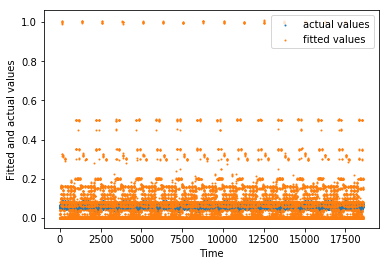

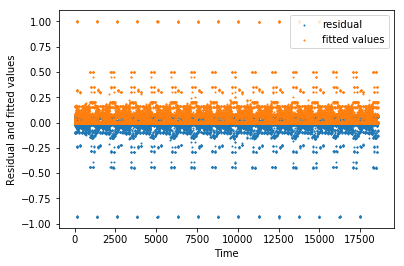

Train RMSE for workflow 0:  [0.035835520779861095, 0.02951891509118551, 0.02630954712453065, 0.024962238121049172, 0.018209437791093158, 0.010376503987379326, 0.009069607811939205, 0.007958804095917777]
Train RMSE for workflow 1:  [0.14876603056260168, 0.12984551886276852, 0.11113444593103634, 0.08939243683226872, 0.06556258032152666, 0.042486438474353294, 0.020758575466296954, 0.008112094032228803]
Train RMSE for workflow 2:  [0.04290932063907724, 0.0384606912493503, 0.03446961025670463, 0.03182363633581566, 0.025911127994652887, 0.021627292114392033, 0.020727054891286872, 0.01932515908511564]
Train RMSE for workflow 3:  [0.0072438788738825345, 0.006379974964684911, 0.006023819910052759, 0.005452823154339548, 0.004902413173250664, 0.0045885270041568825, 0.004370966875411133, 0.004249106224857203]
Train RMSE for workflow 4:  [0.08592193679327194, 0.06919446595560244, 0.0608619463182538, 0.04894093562205807, 0.03614644604872457, 0.025961264049570124, 0.020889595648082297, 0.018406270278

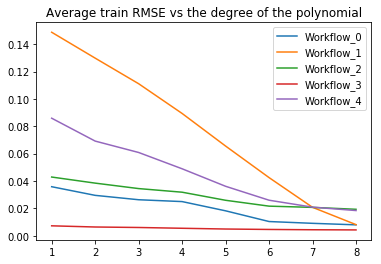

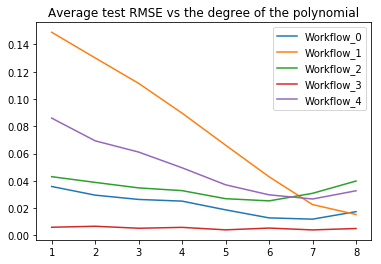

In [40]:
# (d) ii. 
# Try fitting a more complex regression function to your data. You can try a polynomial function
# of your variables. Try increasing the degree of the polynomial to improve your fit. Again, use a 10 
# fold cross validation to evaluate your results. Plot the average train and test RMSE of the trained 
# model against the degree of the polynomial you use. Can you find a threshold on the degree of the fitted 
# polynomial beyond which the generalization error of your model gets worse? Can you explain how cross
# validation helps controlling the complexity of your model?

from sklearn.preprocessing import PolynomialFeatures
X = data[['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']]
y = data['Size of Backup (GB)']
X = np.array(X)
y = np.array(y)
# print(X[1])
X_0 = []
X_1 = []
X_2 = []
X_3 = []
X_4 = []

y_0 = []
y_1 = []
y_2 = []
y_3 = []
y_4 = []

for i in np.arange(X.shape[0]):
    if X[i][3] == 0:
        X_0.append(X[i])
        y_0.append(y[i])
    if X[i][3] == 1:
        X_1.append(X[i])
        y_1.append(y[i])
    if X[i][3] == 2:
        X_2.append(X[i])
        y_2.append(y[i])
    if X[i][3] == 3:
        X_3.append(X[i])
        y_3.append(y[i])
    if X[i][3] == 4:
        X_4.append(X[i])
        y_4.append(y[i])

num_folds =10
X_0 = np.array(X_0)
X_1 = np.array(X_1)
X_2 = np.array(X_2)
X_3 = np.array(X_3)
X_4 = np.array(X_4)

y_0 = np.array(y_0)
y_1 = np.array(y_1)
y_2 = np.array(y_2)
y_3 = np.array(y_3)
y_4 = np.array(y_4)


train_RMSE_rec_0 = []
train_RMSE_rec_1 = []
train_RMSE_rec_2 = []
train_RMSE_rec_3 = []
train_RMSE_rec_4 = []

test_RMSE_rec_0 = []
test_RMSE_rec_1 = []
test_RMSE_rec_2 = []
test_RMSE_rec_3 = []
test_RMSE_rec_4 = []

# rec_0 = 100
# rec_1 = 100
# rec_2 = 100
# rec_3 = 100
# rec_4 = 100
rec = 100


for i in np.arange(8):
#     poly = PolynomialFeatures(degree=i+1)
    print('polynomial degree is ', i+1)
    # Workflow 0
    train_RMSE_0 = 0
    test_RMSE_0 = 0
    poly = PolynomialFeatures(degree=i+1)
    X_0_poly = poly.fit_transform(X_0)
    X_folds_0 = np.array_split(X_0_poly, num_folds, axis = 0)
    y_folds_0 = np.array_split(y_0, num_folds, axis = 0)
    for j in np.arange(10):      
        X_train = np.vstack(X_folds_0[:j] + X_folds_0[j+1:]) 
        X_test = X_folds_0[j]
        y_train = np.hstack(y_folds_0[:j] + y_folds_0[j+1:]) 
        y_test = y_folds_0[j]
        lr = linear_model.LinearRegression()
        lr.fit(X_train, y_train)
        y_train_pred = lr.predict(X_train)
        y_test_pred = lr.predict(X_test)
        train_RMSE_0 += mean_squared_error(y_train, y_train_pred)
        test_RMSE_0 += mean_squared_error(y_test, y_test_pred)
    
    train_RMSE_0 = np.sqrt(train_RMSE_0/num_folds)
    test_RMSE_0 = np.sqrt(test_RMSE_0/num_folds)
    train_RMSE_rec_0.append(train_RMSE_0)
    test_RMSE_rec_0.append(test_RMSE_0)
    if test_RMSE_0 < rec:
        rec = test_RMSE_0
        best_lr = lr
        y_train_pred = best_lr.predict(X_train)
        train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
#     print ("RMSE for workflow 0: ", RMSE_0)

    # Workflow 1
    train_RMSE_1 = 0
    test_RMSE_1 = 0
    poly = PolynomialFeatures(degree=i+1)
    X_1_poly = poly.fit_transform(X_1)
    X_folds_1 = np.array_split(X_1_poly, num_folds, axis = 0)
    y_folds_1 = np.array_split(y_1, num_folds, axis = 0)
    for j in np.arange(10):   
        X_train = np.vstack(X_folds_1[:j] + X_folds_1[j+1:]) 
        X_test = X_folds_1[j]
        y_train = np.hstack(y_folds_1[:j] + y_folds_1[j+1:]) 
        y_test = y_folds_1[j]
        lr = linear_model.LinearRegression()
        lr.fit(X_train, y_train)
        y_train_pred = lr.predict(X_train)
        y_test_pred = lr.predict(X_test)
        train_RMSE_1 += mean_squared_error(y_train, y_train_pred)
        test_RMSE_1 += mean_squared_error(y_test, y_test_pred)
    
    train_RMSE_1 = np.sqrt(train_RMSE_1/num_folds)
    test_RMSE_1 = np.sqrt(test_RMSE_1/num_folds)
    train_RMSE_rec_1.append(train_RMSE_1)
    test_RMSE_rec_1.append(test_RMSE_1)
    if test_RMSE_1 < rec:
        rec = test_RMSE_1
        best_lr = lr
        y_train_pred = best_lr.predict(X_train)
        train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
        
    # Workflow 2
    train_RMSE_2 = 0
    test_RMSE_2 = 0
    poly = PolynomialFeatures(degree=i+1)
    X_2_poly = poly.fit_transform(X_2)
    X_folds_2 = np.array_split(X_2_poly, num_folds, axis = 0)
    y_folds_2 = np.array_split(y_2, num_folds, axis = 0)
    for j in np.arange(10):    
        X_train = np.vstack(X_folds_2[:j] + X_folds_2[j+1:]) 
        X_test = X_folds_2[j]
        y_train = np.hstack(y_folds_2[:j] + y_folds_2[j+1:]) 
        y_test = y_folds_2[j]
        lr = linear_model.LinearRegression()
        lr.fit(X_train, y_train)
        y_train_pred = lr.predict(X_train)
        y_test_pred = lr.predict(X_test)
        train_RMSE_2 += mean_squared_error(y_train, y_train_pred)
        test_RMSE_2 += mean_squared_error(y_test, y_test_pred)
    
    train_RMSE_2 = np.sqrt(train_RMSE_2/num_folds)
    test_RMSE_2 = np.sqrt(test_RMSE_2/num_folds)
    train_RMSE_rec_2.append(train_RMSE_2)
    test_RMSE_rec_2.append(test_RMSE_2)
    if test_RMSE_2 < rec:
        rec = test_RMSE_2
        best_lr = lr
        y_train_pred = best_lr.predict(X_train)
        train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
        
    # Workflow 3
    train_RMSE_3 = 0
    test_RMSE_3 = 0
    poly = PolynomialFeatures(degree=i+1)
    X_3_poly = poly.fit_transform(X_3)
    X_folds_3 = np.array_split(X_3_poly, num_folds, axis = 0)
    y_folds_3 = np.array_split(y_3, num_folds, axis = 0)
    for j in np.arange(10):  
        X_train = np.vstack(X_folds_3[:j] + X_folds_3[j+1:]) 
        X_test = X_folds_3[i]
        y_train = np.hstack(y_folds_3[:j] + y_folds_3[j+1:]) 
        y_test = y_folds_3[i]
        lr = linear_model.LinearRegression()
        lr.fit(X_train, y_train)
        y_train_pred = lr.predict(X_train)
        y_test_pred = lr.predict(X_test)
        train_RMSE_3 += mean_squared_error(y_train, y_train_pred)
        test_RMSE_3 += mean_squared_error(y_test, y_test_pred)
    
    train_RMSE_3 = np.sqrt(train_RMSE_3/num_folds)
    test_RMSE_3 = np.sqrt(test_RMSE_3/num_folds)
    train_RMSE_rec_3.append(train_RMSE_3)
    test_RMSE_rec_3.append(test_RMSE_3)
    if test_RMSE_3 < rec:
        rec = test_RMSE_3
        best_lr = lr
        y_train_pred = best_lr.predict(X_train)
        train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
        
    # Workflow 4
    train_RMSE_4 = 0
    test_RMSE_4 = 0
    poly = PolynomialFeatures(degree=i+1)
    X_4_poly = poly.fit_transform(X_4)
    X_folds_4 = np.array_split(X_4_poly, num_folds, axis = 0)
    y_folds_4 = np.array_split(y_4, num_folds, axis = 0)
    for j in np.arange(10):  
        X_train = np.vstack(X_folds_4[:j] + X_folds_4[j+1:]) 
        X_test = X_folds_4[j]
        y_train = np.hstack(y_folds_4[:j] + y_folds_4[j+1:]) 
        y_test = y_folds_4[j]
        lr = linear_model.LinearRegression()
        lr.fit(X_train, y_train)
        y_train_pred = lr.predict(X_train)
        y_test_pred = lr.predict(X_test)
        train_RMSE_4 += mean_squared_error(y_train, y_train_pred)
        test_RMSE_4 += mean_squared_error(y_test, y_test_pred)
    
    train_RMSE_4 = np.sqrt(train_RMSE_4/num_folds)
    test_RMSE_4 = np.sqrt(test_RMSE_4/num_folds)
    train_RMSE_rec_4.append(train_RMSE_4)
    test_RMSE_rec_4.append(test_RMSE_4)
    if test_RMSE_4 < rec:
        rec = test_RMSE_4
        best_lr = lr
        y_train_pred = best_lr.predict(X_train)
        train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))

print('Done')
print('Best train RMSE is ', train_RMSE)
print('Best test RMSE is ', rec)
y_pred = cross_val_predict(best_lr, X, y, cv = 10)
two_plots(y_pred, y)
    

print("Train RMSE for workflow 0: ", train_RMSE_rec_0)
print("Train RMSE for workflow 1: ", train_RMSE_rec_1)
print("Train RMSE for workflow 2: ", train_RMSE_rec_2)
print("Train RMSE for workflow 3: ", train_RMSE_rec_3)
print("Train RMSE for workflow 4: ", train_RMSE_rec_4)
print("Test RMSE for workflow 0: ", test_RMSE_rec_0)   
print("Test RMSE for workflow 1: ", test_RMSE_rec_1)   
print("Test RMSE for workflow 2: ", test_RMSE_rec_2)   
print("Test RMSE for workflow 3: ", test_RMSE_rec_3)   
print("Test RMSE for workflow 4: ", test_RMSE_rec_4)   

plt.figure()
plt.plot(np.arange(1,9), train_RMSE_rec_0, label = 'Workflow_0')
plt.plot(np.arange(1,9), train_RMSE_rec_1, label = 'Workflow_1')
plt.plot(np.arange(1,9), train_RMSE_rec_2, label = 'Workflow_2')
plt.plot(np.arange(1,9), train_RMSE_rec_3, label = 'Workflow_3')
plt.plot(np.arange(1,9), train_RMSE_rec_4, label = 'Workflow_4')
plt.title('Average train RMSE vs the degree of the polynomial')
plt.legend(loc='upper right')

plt.figure()
plt.plot(np.arange(1,9), test_RMSE_rec_0, label = 'Workflow_0')
plt.plot(np.arange(1,9), test_RMSE_rec_1, label = 'Workflow_1')
plt.plot(np.arange(1,9), test_RMSE_rec_2, label = 'Workflow_2')
plt.plot(np.arange(1,9), test_RMSE_rec_3, label = 'Workflow_3')
plt.plot(np.arange(1,9), test_RMSE_rec_4, label = 'Workflow_4')
plt.title('Average test RMSE vs the degree of the polynomial')
plt.legend(loc='upper right')
plt.show()


In [39]:
print("Train RMSE for workflow 0: ", train_RMSE_rec_0)
print("Train RMSE for workflow 1: ", train_RMSE_rec_1)
print("Train RMSE for workflow 2: ", train_RMSE_rec_2)
print("Train RMSE for workflow 3: ", train_RMSE_rec_3)
print("Train RMSE for workflow 4: ", train_RMSE_rec_4)
print("Test RMSE for workflow 0: ", test_RMSE_rec_0)   
print("Test RMSE for workflow 1: ", test_RMSE_rec_1)   
print("Test RMSE for workflow 2: ", test_RMSE_rec_2)   
print("Test RMSE for workflow 3: ", test_RMSE_rec_3)   
print("Test RMSE for workflow 4: ", test_RMSE_rec_4)  

Train RMSE for workflow 0:  [0.035835520779861095, 0.02951891509118551, 0.02630954712453065, 0.024962238121049172, 0.018209437791093158, 0.010376503987379326, 0.009069607811939205, 0.007958804095917777]
Train RMSE for workflow 1:  [0.14876603056260168, 0.12984551865512522, 0.11113444593103634, 0.08939243683226872, 0.06556258032152666, 0.042486438474353294, 0.020758575466296954]
Train RMSE for workflow 2:  [0.04290932063907724, 0.03846069121462554, 0.03446961025670463, 0.03182363633581566, 0.025911127994652887, 0.021627292114392033, 0.020727054891286872]
Train RMSE for workflow 3:  [0.0072438788738825345, 0.006379974964684911, 0.006023819910052759, 0.005452823154339548, 0.004902413173250664, 0.0045885270041568825, 0.004370966875411133]
Train RMSE for workflow 4:  [0.08592193679327194, 0.06919446655393588, 0.0608619463182538, 0.04894093562205807, 0.03614644604872457, 0.025961264049570124, 0.020889595648082297]
Test RMSE for workflow 0:  [0.035886970248931206, 0.029540009203662437, 0.0263

### (e) Use k-nearest neighbor regression and find the best parameter
- k-nearest neighbor regression is performed by using *kNeighborsRegressor* and to find the best parameter combination, we use *GridSearchCV* provided by sklearn to search through KNN parameters including n_neightbors, weights, algorithm, leaf_size and p. 
- The best parameter we can find is : {'algorithm': 'ball_tree', 'leaf_size': 25, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}, by using such parameters, the best train RMSE is 0 and the best test RMSE is 0.030795699408640954. Accordingly, we can plot the graphs based on fitted values and actual values.

KNeighborsRegressor(algorithm='ball_tree', leaf_size=25, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=1,
          weights='distance')
{'algorithm': 'ball_tree', 'leaf_size': 25, 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best train RMSE is  0.0
Best test RMSE is  0.030795699408640954


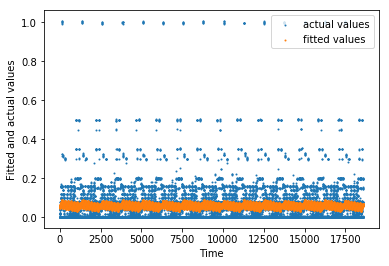

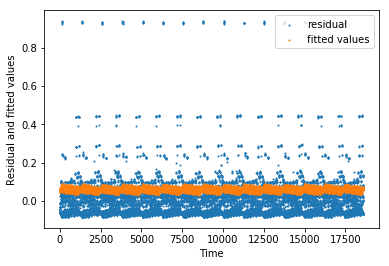

In [23]:
# (e) Use k-nearest neighbor regression and find the best parameter
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
X = data[['Week #', 'Day of Week', 'Backup Start Time - Hour of Day', 'Work-Flow-ID', 'File Name']]
y = data['Size of Backup (GB)']
X = np.array(X)
y = np.array(y)

# for i, weights in enumerate(['uniform', 'distance']):
#     for j in n_neighbors in np.arange(3, 10):
#         knn = KNeighborsRegressor(j, weights=weights)
#     #     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
#         y_pred = cross_val_predict(knn, X, y, cv=10)
#         RMSE =  np.sqrt(mean_squared_error(y, y_pred))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)    
parameters = {'n_neighbors':[3,5,7,9], 'weights':('uniform', 'distance'), \
              'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'), \
             'leaf_size':[25, 30, 35], 'p': [1, 2]}
knn = KNeighborsRegressor()
clf = GridSearchCV(knn, parameters)
clf.fit(X_train, y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
train_RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))
# clf.cv_results.keys()
print(clf.best_estimator_)
print(clf.best_params_)
print('Best train RMSE is ', train_RMSE)
print('Best test RMSE is ', test_RMSE)
two_plots(y, y_pred)

## 3. Compare these regression models you have used and write some comments, such as which model is best and handling categorical features, which model is good at handling sparse features or not? Which model overall generates the best results?

Through this project, we investigate on linear regression, random forest regression, knn regression, neural network on the whole dataset. During performing linear regression, we have further tried data preprocessing, feature selection, feature encoding, different regularization methods. As for random forest, we discuss our results based on test RMSE as well as out-of-bag-error and visualize the best decision tree to gain a better intuition. In neural networks and knn, we report the best combination of different parameters. To see if performance will be improved for each of the workflows separately, we perform linear regression model on each workflow and also try polynomial features as preprocessing methods. 

It can be seen that linear regression is good at handling sparse features that one-hot-encoding on most important features can improve the performance a lot. However, it is not good at categorical features that even with standardization, the results do not improve a lot. Random forest is good at categorical features but not sparse features. For categorical features, random forest will utilize equality rules so it is easy to split. However, sparse features requires many splits as there are many categories thus results in very poorly performance. NN overall gives satisfactory results on one-hot-encoded features, unlike random forest, which will give crazy high test RMSE if using sparse features. KNN is very likely to overfitting, which would give a very high test RMSE if k is not chosen properly. Polynomical features with linear regression on each flow gives the most satisfactory test RMSE that the smallest can be only 0.00405.